# Práctica 1 — Graph Neural Networks (GNN)

**Autor:** Jordi Blasco Lozano  

### Índice
1. Resumen e introducción
2. Implementación (funciones y clases auxiliares)
3. Ejercicio 1 — Dataset sintético (SBM)
4. Ejercicio 2 — Experimentos de clasificación de nodos
   - Parte A: Dataset sintético
   - Parte B: Cora y Citeseer
5. Exploración de hiperparámetros
6. Discusión y conclusiones


## Resumen

Este notebook resuelve la **Práctica 1** comparando un baseline que ignora la topología (**MLP**) frente a un modelo con *message passing* (**GCN** de 2 capas). Para ello: (i) genero un dataset sintético con **2000 nodos** y **4 comunidades** mediante un *Stochastic Block Model*; (ii) entreno ambos modelos en **10 particiones 60/20/20** y reporto media ± desviación estándar; (iii) repito el experimento en **Cora** y **Citeseer** usando las máscaras oficiales; y (iv) realizo un barrido de hiperparámetros (dimensión oculta, learning rate, dropout, weight decay y optimizador) para analizar sensibilidad y estabilidad.

## 1. Introducción

La clasificación de nodos es una tarea (semi-)supervisada donde cada nodo dispone de un vector de características $\mathbf{x}_i$ y una etiqueta $y_i$, pero solo una fracción de las etiquetas es observable durante el entrenamiento. El objetivo principal de esta práctica es evidenciar por qué los modelos que tratan cada nodo como una muestra independiente (MLP) pueden fallar cuando la información está “distribuida” en la **estructura del grafo**, y cómo una GCN recupera esa información agregando características del vecindario.

La hipótesis que validaré es que el mecanismo de *message passing* suaviza el ruido de las features individuales (promediado local), haciendo emerger la señal de clase cuando existe **homofilia topológica** (vecinos con la misma etiqueta).


## 2. Implementación: funciones y clases auxiliares

En este bloque agrupo los *imports*, funciones de ayuda (particionado, visualización) y las clases de modelos y entrenamiento. La idea es mantener el notebook limpio: en los ejercicios únicamente llamo a estas funciones, evitando repetir código y facilitando la lectura de la entrega.


In [1]:
# Imports necesarios
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import os
from IPython.display import display

# Crear carpeta de salida para figuras (evita errores al guardar plots)
os.makedirs('images', exist_ok=True)


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree

# Configuración de reproducibilidad
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Definir dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Using device: {device}")
print("Setup completado")

PyTorch version: 2.7.1+cu118
CUDA available: True
Using device: cuda
Setup completado


### 2.1 Funciones utilitarias

In [2]:
def create_masks(num_nodes, num_classes, train_ratio = 0.6, val_ratio = 0.2, seed = 0):
    """
    Create train/val/test masks for node classification.
    
    Args:
        num_nodes: Total number of nodes
        num_classes: Number of classes
        train_ratio: Fraction of nodes for training
        val_ratio: Fraction of nodes for validation
        seed: Random seed for reproducibility
    
    Returns:
        train_mask, val_mask, test_mask as boolean tensors
    """
    np.random.seed(seed)
    
    indices = np.random.permutation(num_nodes)
    train_size = int(num_nodes * train_ratio)
    val_size = int(num_nodes * val_ratio)
    
    train_idx = indices[:train_size]
    val_idx = indices[train_size:train_size + val_size]
    test_idx = indices[train_size + val_size:]
    
    train_mask = torch.zeros(num_nodes, dtype = torch.bool)
    val_mask = torch.zeros(num_nodes, dtype = torch.bool)
    test_mask = torch.zeros(num_nodes, dtype = torch.bool)
    
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True
    
    return train_mask, val_mask, test_mask



### 2.2 Funciones de visualización

In [3]:
def visualize_embeddings(embeddings, labels, title, filename, num_classes = 4):
    """
    Visualize node embeddings using t-SNE.
    
    Args:
        embeddings: Node embeddings [num_nodes, embedding_dim]
        labels: Node labels [num_nodes]
        title: Plot title
        filename: Output filename
        num_classes: Number of classes for the color map
    """
    # Apply t-SNE (ensure CPU tensors for numpy conversion)
    tsne = TSNE(n_components = 2, random_state = 42, perplexity = 30)
    embeddings_2d = tsne.fit_transform(embeddings.detach().cpu().numpy())
    
    # Plot
    plt.figure(figsize = (10, 8))
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#a65628', '#f781bf']
    
    for class_idx in range(num_classes):
        mask = labels == class_idx
        plt.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            c = colors[class_idx % len(colors)],
            label = f'Class {class_idx}',
            alpha = 0.7,
            s = 50
        )
    
    plt.legend()
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.tight_layout()
    plt.savefig(filename, dpi = 150)
    plt.show()


@torch.no_grad()
def get_embeddings(model, data):
    """
    Extract node embeddings from the model (before the final layer).
    Handles CUDA: moves data to model's device, returns CPU tensors.
    """
    model.eval()
    dev = next(model.parameters()).device
    x = data.x.to(dev)
    edge_index = data.edge_index.to(dev)
    
    if isinstance(model, GCN):
        x = model.conv1(x, edge_index)
        x = F.relu(x)
        return x.cpu()
    else:
        x = model.fc1(x)
        x = F.relu(x)
        return x.cpu()

### 2.3 Modelos (MLP y GCN)

In [4]:
class MLP(nn.Module):
    """
    Simple Multi-Layer Perceptron for node classification.
    This baseline ignores the graph structure.
    """
    
    def __init__(self, in_channels, hidden_channels, out_channels, dropout = 0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # First layer
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        # Second layer (output)
        x = self.fc2(x)
        return x


class GCN(nn.Module):
    """
    Graph Convolutional Network for node classification.
    """
    
    def __init__(self, in_channels, hidden_channels, out_channels, dropout = 0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        # Second GCN layer
        x = self.conv2(x, edge_index)
        return x

### 2.4 Clase de entrenamiento (`GraphTrainer`)

He implementado una clase unificada para centralizar el entrenamiento y la evaluación. En concreto permite:

- Seleccionar hiperparámetros (`num_epochs`, `lr`, `weight_decay`, `hidden_channels`, `dropout`, `optimizer`, `patience`)
- Entrenar uno o varios modelos sobre uno o varios datasets (incluyendo *multiple runs*)
- Obtener DataFrames con el historial por época y un resumen final con medias y desviaciones estándar
- Generar visualizaciones: curvas de entrenamiento y gráfica comparativa (bar chart)


In [5]:
class GraphTrainer:
    """
    Unified training class for graph node classification experiments.
    Supports training one or multiple models on one or multiple datasets.
    All training data is stored in DataFrames instead of printed.
    Includes early stopping based on validation accuracy and CUDA support.
    """
    
    def __init__(self, num_epochs = 200, lr = 0.01, weight_decay = 5e-4,
                 hidden_channels = 64, dropout = 0.5, optimizer_type = 'Adam',
                 patience = 20, device = None):
        self.num_epochs = num_epochs
        self.lr = lr
        self.weight_decay = weight_decay
        self.hidden_channels = hidden_channels
        self.dropout = dropout
        self.optimizer_type = optimizer_type
        self.patience = patience
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Internal storage
        self._results = []       # Per-run summary results
        self._histories = []     # Per-run epoch-level histories
    
    # ── Private: optimizer factory ──────────────────────────────────────
    def _create_optimizer(self, model):
        if self.optimizer_type == 'Adam':
            return torch.optim.Adam(model.parameters(), lr = self.lr, weight_decay = self.weight_decay)
        elif self.optimizer_type == 'SGD':
            return torch.optim.SGD(model.parameters(), lr = self.lr, weight_decay = self.weight_decay)
        else:
            raise ValueError(f"Optimizer '{self.optimizer_type}' not supported. Use 'Adam' or 'SGD'.")
    
    # ── Private: single epoch ───────────────────────────────────────────
    def _train_epoch(self, model, data, optimizer, criterion, train_mask):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        if isinstance(model, MLP):
            out = model(data.x)
        else:
            out = model(data.x, data.edge_index)
        
        # Compute loss only on training nodes
        loss = criterion(out[train_mask], data.y[train_mask])
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        return loss.item()
    
    # ── Private: evaluate ───────────────────────────────────────────────
    @torch.no_grad()
    def _evaluate(self, model, data, mask):
        model.eval()
        
        # Forward pass
        if isinstance(model, MLP):
            out = model(data.x)
        else:
            out = model(data.x, data.edge_index)
        
        # Get predictions
        pred = out.argmax(dim = 1)
        
        # Compute accuracy
        correct = (pred[mask] == data.y[mask]).sum().item()
        total = mask.sum().item()
        
        return correct / total
    
    # ── Private: run single experiment (early stopping + CUDA) ──────────
    def _run_single(self, model, data, masks):
        # Move model to device (CUDA if available)
        model = model.to(self.device)
        
        # Create data copy on device (avoids modifying the original)
        data_dev = Data(
            x = data.x.to(self.device),
            edge_index = data.edge_index.to(self.device),
            y = data.y.to(self.device)
        )
        
        optimizer = self._create_optimizer(model)
        criterion = nn.CrossEntropyLoss()
        
        train_mask = masks['train'].to(self.device)
        val_mask = masks['val'].to(self.device)
        test_mask = masks['test'].to(self.device)
        
        history = {
            'train_loss': [],
            'train_acc': [],
            'val_acc': [],
            'test_acc': []
        }
        
        best_val_acc = 0
        best_test_acc = 0
        patience_counter = 0
        
        for epoch in range(self.num_epochs):
            # Training
            loss = self._train_epoch(model, data_dev, optimizer, criterion, train_mask)
            
            # Evaluation
            train_acc = self._evaluate(model, data_dev, train_mask)
            val_acc = self._evaluate(model, data_dev, val_mask)
            test_acc = self._evaluate(model, data_dev, test_mask)
            
            # Store history
            history['train_loss'].append(loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)
            history['test_acc'].append(test_acc)
            
            # Track best model based on validation accuracy
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_test_acc = test_acc
                patience_counter = 0
            else:
                patience_counter += 1
            
            # Early stopping based on validation accuracy
            if self.patience > 0 and patience_counter >= self.patience:
                break
        
        return {
            'history': history,
            'best_val_acc': best_val_acc,
            'best_test_acc': best_test_acc,
            'epochs_trained': len(history['train_loss'])
        }
    
    # ── Public: train ───────────────────────────────────────────────────
    def train(self, datasets, model_classes, masks_dict = None):
        """
        Train models on datasets. No prints — everything stored internally.
        
        Args:
            datasets:      dict {name: PyG Data}
                           e.g. {'Custom': data} or {'Cora': cora_data, 'Citeseer': cite_data}
            model_classes: dict {name: class}
                           e.g. {'MLP': MLP, 'GCN': GCN}
            masks_dict:    dict {dataset_name: list of mask dicts} or None.
                           If None, uses data.train_mask / val_mask / test_mask (single run).
        """
        self._results = []
        self._histories = []
        
        total_tasks = 0
        for ds_name, data in datasets.items():
            ds_masks = masks_dict.get(ds_name) if masks_dict else None
            if ds_masks is None:
                ds_masks = [{'train': data.train_mask, 'val': data.val_mask, 'test': data.test_mask}]
            total_tasks += len(model_classes) * len(ds_masks)
        
        pbar = tqdm(total = total_tasks, desc = 'Training')
        
        for ds_name, data in datasets.items():
            ds_masks = masks_dict.get(ds_name) if masks_dict else None
            if ds_masks is None:
                ds_masks = [{'train': data.train_mask, 'val': data.val_mask, 'test': data.test_mask}]
            
            num_classes = int(data.y.max()) + 1
            
            for model_name, model_cls in model_classes.items():
                for run_idx, masks in enumerate(ds_masks):
                    # Create fresh model for each run
                    model = model_cls(
                        in_channels = data.num_node_features,
                        hidden_channels = self.hidden_channels,
                        out_channels = num_classes,
                        dropout = self.dropout
                    )
                    
                    result = self._run_single(model, data, masks)
                    
                    self._results.append({
                        'Dataset': ds_name,
                        'Model': model_name,
                        'Run': run_idx,
                        'Best Val Acc': result['best_val_acc'],
                        'Best Test Acc': result['best_test_acc'],
                        'Epochs Trained': result['epochs_trained'],
                    })
                    self._histories.append({
                        'dataset': ds_name,
                        'model': model_name,
                        'run': run_idx,
                        'history': result['history'],
                    })
                    pbar.update(1)
        
        pbar.close()
    
    # ── Public: get training DataFrame ──────────────────────────────────
    def get_training_df(self, dataset_name = None, model_name = None, run = 0):
        """
        Returns a DataFrame with epoch-by-epoch training data for a specific
        dataset/model/run combination.
        """
        for h in self._histories:
            match = True
            if dataset_name and h['dataset'] != dataset_name:
                match = False
            if model_name and h['model'] != model_name:
                match = False
            if h['run'] != run:
                match = False
            if match:
                df = pd.DataFrame(h['history'])
                df.index.name = 'Epoch'
                df.columns = ['Train Loss', 'Train Acc', 'Val Acc', 'Test Acc']
                return df
        return pd.DataFrame()
    
    # ── Public: get results summary DataFrame ───────────────────────────
    def get_results_df(self):
        """
        Returns a summary DataFrame with mean ± std of test and val accuracy
        for each dataset/model combination. Includes avg epochs trained (early stopping).
        """
        df = pd.DataFrame(self._results)
        summary = df.groupby(['Dataset', 'Model']).agg(
            Mean_Test  = ('Best Test Acc', 'mean'),
            Std_Test   = ('Best Test Acc', 'std'),
            Mean_Val   = ('Best Val Acc', 'mean'),
            Std_Val    = ('Best Val Acc', 'std'),
            Runs       = ('Run', 'count'),
            Avg_Epochs = ('Epochs Trained', 'mean')
        ).reset_index()
        
        summary['Std_Test'] = summary['Std_Test'].fillna(0)
        summary['Std_Val'] = summary['Std_Val'].fillna(0)
        
        summary['Test Accuracy'] = summary.apply(
            lambda r: f"{r['Mean_Test']:.4f} ± {r['Std_Test']:.4f}" if r['Runs'] > 1
            else f"{r['Mean_Test']:.4f}", axis = 1
        )
        summary['Val Accuracy'] = summary.apply(
            lambda r: f"{r['Mean_Val']:.4f} ± {r['Std_Val']:.4f}" if r['Runs'] > 1
            else f"{r['Mean_Val']:.4f}", axis = 1
        )
        summary['Avg Epochs'] = summary['Avg_Epochs'].apply(lambda x: f"{x:.0f}")
        return summary[['Dataset', 'Model', 'Test Accuracy', 'Val Accuracy', 'Runs', 'Avg Epochs']]
    
    # ── Public: plot training curves ────────────────────────────────────
    def plot_training_curves(self, dataset_name = None, run = 0, filename = None):
        """
        Plot training curves (loss, train acc, val acc) for all models
        in each dataset. If dataset_name is given, only that dataset is plotted.
        """
        histories = [h for h in self._histories if h['run'] == run]
        if dataset_name:
            histories = [h for h in histories if h['dataset'] == dataset_name]
        
        datasets_in_hist = sorted(set(h['dataset'] for h in histories))
        
        for ds in datasets_in_hist:
            ds_histories = [h for h in histories if h['dataset'] == ds]
            
            fig, axes = plt.subplots(1, 3, figsize = (15, 4))
            fig.suptitle(f'Training Curves — {ds}', fontsize = 14, fontweight = 'bold')
            
            for h in ds_histories:
                hist = h['history']
                label = h['model']
                axes[0].plot(hist['train_loss'], label = label, alpha = 0.8)
                axes[1].plot(hist['train_acc'], label = label, alpha = 0.8)
                axes[2].plot(hist['val_acc'], label = label, alpha = 0.8)
            
            axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Training Loss')
            axes[0].set_title('Training Loss'); axes[0].legend(); axes[0].grid(True, alpha = 0.3)
            axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy')
            axes[1].set_title('Training Accuracy'); axes[1].legend(); axes[1].grid(True, alpha = 0.3)
            axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('Accuracy')
            axes[2].set_title('Validation Accuracy'); axes[2].legend(); axes[2].grid(True, alpha = 0.3)
            
            plt.tight_layout()
            if filename:
                save_name = f"{filename}_{ds}.png" if len(datasets_in_hist) > 1 else f"{filename}.png"
                plt.savefig(save_name, dpi = 150, bbox_inches = 'tight')
            plt.show()
    
    # ── Public: plot bar chart ──────────────────────────────────────────
    def plot_bar_chart(self, filename = None):
        """
        Plot grouped bar chart comparing model test accuracies across datasets.
        """
        df = pd.DataFrame(self._results)
        summary = df.groupby(['Dataset', 'Model'])['Best Test Acc'].agg(['mean', 'std']).reset_index()
        summary['std'] = summary['std'].fillna(0)
        
        datasets = summary['Dataset'].unique()
        models = summary['Model'].unique()
        
        fig, ax = plt.subplots(figsize = (max(6, len(datasets) * 2.5), 5))
        x = np.arange(len(datasets))
        width = 0.8 / len(models)
        
        for i, model in enumerate(models):
            model_data = summary[summary['Model'] == model]
            means = [model_data[model_data['Dataset'] == ds]['mean'].values[0] for ds in datasets]
            stds  = [model_data[model_data['Dataset'] == ds]['std'].values[0] for ds in datasets]
            offset = (i - len(models) / 2 + 0.5) * width
            bars = ax.bar(x + offset, means, width, yerr = stds, label = model, capsize = 4, alpha = 0.85)
            for bar, mean_val in zip(bars, means):
                ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 0.015,
                        f'{mean_val:.3f}', ha = 'center', va = 'bottom', fontsize = 9)
        
        ax.set_xlabel('Dataset')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Model Comparison — Test Accuracy')
        ax.set_xticks(x)
        ax.set_xticklabels(datasets)
        ax.legend()
        ax.grid(True, alpha = 0.3, axis = 'y')
        ax.set_ylim([0, 1.1])
        
        plt.tight_layout()
        if filename:
            plt.savefig(filename, dpi = 150, bbox_inches = 'tight')
        plt.show()

## 3. Ejercicio 1 — Dataset sintético (Custom / SBM)

### 3.1 Diseño del dataset sintético

He diseñado un dataset sintético con el objetivo explícito de construir un caso donde **las features individuales sean poco informativas**, pero la **estructura del grafo** sí contenga señal suficiente. De esta forma, un MLP debería comportarse cerca del azar, mientras que una GCN debería recuperar la clase gracias al vecindario.

**Estructura (Stochastic Block Model):**
- **Nodos:** 2000, repartidos en **4 comunidades** (500 nodos por clase).
- **Homofilia estructural:** $p_{\text{intra}} = 0.2$ y $p_{\text{inter}} = 0.001$, generando comunidades densas y pocas aristas entre clases.

**Características de nodo:**
- Dimensión: $\mathbf{x}_i \in \mathbb{R}^{16}$.
- Generación con señal débil y ruido dominante:
$$
\mathbf{x}_i = \alpha\,\mathbf{c}_{y_i} + \boldsymbol{\epsilon}, \qquad \boldsymbol{\epsilon} \sim \mathcal{N}(0, \sigma^2 I)
$$
con $\alpha = 0.2$ y $\sigma = 1.0$.

En este régimen, si se ignora la topología, la tarea es prácticamente inabordable: cada nodo por separado está contaminado por ruido. En cambio, al promediar información de vecinos (mediante message passing), la varianza efectiva del ruido se reduce y emerge la señal compartida por la comunidad.

Si las características fueran perfectas, un MLP obtendría casi 100% de acierto y la estructura del grafo sería irrelevante. Al introducir mucho ruido, forzamos al modelo a depender de la estructura: un modelo debe tener en cuenta a los vecinos para desambiguar la clase del nodo. Esto simula escenarios reales donde la información local es imperfecta.

In [6]:
# Parameters for our synthetic graph
num_nodes = 2000
num_classes = 4
nodes_per_class = num_nodes // num_classes
feature_dim = 16

# Create a stochastic block model graph
# This generates a graph with community structure
sizes = [nodes_per_class] * num_classes
# Probability matrix: higher probability within communities
p_intra = 0.2  # Probability of edge within same community
p_inter = 0.001  # Probability of edge between different communities
probs = np.full((num_classes, num_classes), p_inter)
np.fill_diagonal(probs, p_intra)

G = nx.stochastic_block_model(sizes, probs, seed = 42)

# Get the ground truth community assignments
node_labels = np.array([i // nodes_per_class for i in range(num_nodes)])

# Create class centers in the feature space with SMALL magnitude
# The key difference: small class centers and large noise
class_centers = np.random.randn(num_classes, feature_dim) * 0.3

# Assign features to nodes based on their class
# Each node gets a WEAK class signal drowned in LARGE noise
node_features = np.zeros((num_nodes, feature_dim))
for i in range(num_nodes):
    label = node_labels[i]
    # Large noise dominates the weak class signal
    noise = np.random.randn(feature_dim) * 1.0            # Large noise
    weak_signal = class_centers[label] * 0.2              # Weak signal
    node_features[i] = weak_signal + noise

# Convert features and labels to PyTorch tensors
x = torch.tensor(node_features, dtype = torch.float)
y = torch.tensor(node_labels, dtype = torch.long)

# Convert NetworkX graph to edge_index format
# PyG uses COO format: edge_index[0] contains source nodes, edge_index[1] contains target nodes
edge_list = list(G.edges())
edge_index = torch.tensor(edge_list, dtype = torch.long).t().contiguous()

# For undirected graphs, we need edges in both directions
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim = 1)

# Create the PyG Data object
custom_data = Data(x = x, edge_index = edge_index, y = y)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Feature matrix shape: {node_features.shape}")
print(f"Feature statistics - Mean: {node_features.mean():.3f}, Std: {node_features.std():.3f}")
print(f"Number of classes: {num_classes}")
print(f"Is undirected: {custom_data.is_undirected()}")

Number of nodes: 2000
Number of edges: 101270
Feature matrix shape: (2000, 16)
Feature statistics - Mean: -0.012, Std: 1.001
Number of classes: 4
Is undirected: True


### 3.2 Visualización del grafo

A continuación muestro la estructura del SBM coloreando cada comunidad. El objetivo es comprobar visualmente que la homofilia generada (muchas aristas intra-comunidad y pocas inter-comunidad) es consistente con el diseño del dataset.


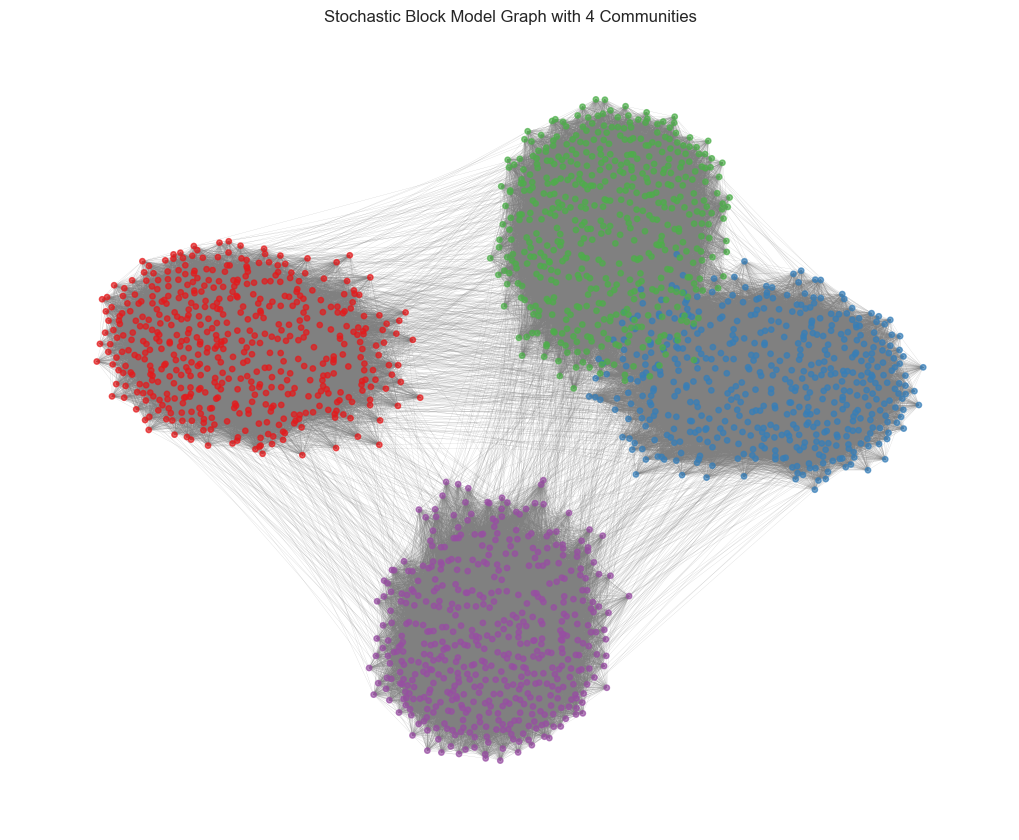

In [7]:
# Visualize the graph structure
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
node_colors = [colors[label] for label in node_labels]

plt.figure(figsize = (10, 8))
pos = nx.spring_layout(G, seed = 42, k = 0.5)
nx.draw(G, pos, node_color = node_colors, node_size = 15, 
        edge_color = 'gray', alpha = 0.7, width = 0.1)
plt.title("Stochastic Block Model Graph with 4 Communities")
plt.tight_layout()
plt.savefig("images/sbm_graph.png", dpi = 300)
plt.show()

### 3.3 Particionado train/val/test (10 runs)

Para evaluar de forma robusta, genero **10 particiones independientes** con proporciones **60% / 20% / 20%**. Así obtengo una estimación media y una desviación estándar del rendimiento que no dependen de una única división concreta.


In [8]:
# Create masks for 10 different runs
num_runs = 10
all_masks = []

for run in range(num_runs):
    train_mask, val_mask, test_mask = create_masks(
        custom_data.num_nodes, num_classes, seed = run
    )
    all_masks.append({
        'train': train_mask,
        'val': val_mask,
        'test': test_mask
    })
    
# Verify the first split
print(f"Run 0 - Train nodes: {all_masks[0]['train'].sum().item()}")
print(f"Run 0 - Val nodes: {all_masks[0]['val'].sum().item()}")
print(f"Run 0 - Test nodes: {all_masks[0]['test'].sum().item()}")

Run 0 - Train nodes: 1200
Run 0 - Val nodes: 400
Run 0 - Test nodes: 400


### 3.4 Análisis exploratorio del dataset sintético

La visualización confirma que la estructura de comunidad es clara: se observan 4 clusters densos con pocas aristas inter-comunidad, exactamente lo esperado del modelo generativo. Esta topología es ideal para GNNs porque el principio de homofilia se cumple fuertemente: los nodos vecinos tienden a pertenecer a la misma clase.

A nivel cuantitativo, el grafo resultante tiene **2000 nodos** y del orden de **$10^5$ aristas** (antes de duplicar direcciones en PyG), lo que mantiene el entrenamiento manejable en CPU y, a la vez, asegura conectividad suficiente dentro de cada comunidad.


## 4. Ejercicio 2 — Node Classification Experiments

### 4.1 Parte A — Dataset sintético (Custom)

En esta primera parte entreno sobre el dataset sintético SBM un **MLP** (ignora la estructura) y una **GCN de 2 capas** (aprovecha la topología). Ambos modelos comparten la misma plantilla: una capa oculta de 64 unidades con ReLU y dropout de 0.5, seguida de una capa de salida (4 clases). La diferencia es que:

- **MLP:** aplica transformaciones estándar $\mathbf{h} = \sigma(\mathbf{W}\mathbf{x} + \mathbf{b})$ y es “ciego” a la matriz de adyacencia.
- **GCN:** incorpora agregación de vecinos $\mathbf{H}^{(l+1)} = \sigma(\hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}\mathbf{H}^{(l)}\mathbf{W}^{(l)})$.

En el contexto de features con ruido gaussiano, esta agregación actúa como un promedio local que reduce varianza y hace emerger la señal de comunidad.

**Protocolo experimental:** ejecuto **10 runs** con particiones 60/20/20. Uso `accuracy` como métrica y aplico *early stopping* sobre `val accuracy` (patience=20). La clase `GraphTrainer` encapsula el pipeline (entrenamiento, evaluación, historiales y tablas resumen).


In [9]:
# Train MLP and GCN on Custom Dataset across 10 runs
trainer_custom = GraphTrainer(
    num_epochs = 200,
    lr = 0.01,
    weight_decay = 5e-4,
    hidden_channels = 64,
    dropout = 0.5,
    optimizer_type = 'Adam'
)

trainer_custom.train(
    datasets = {'Custom': custom_data},
    model_classes = {'MLP': MLP, 'GCN': GCN},
    masks_dict = {'Custom': all_masks}
)

Training: 100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


In [10]:
# Results summary — Custom Dataset
trainer_custom.get_results_df()

,Dataset,Model,Test Accuracy,Val Accuracy,Runs,Avg Epochs
0,Custom,GCN,0.9992 ± 0.0017,1.0000 ± 0.0000,10,24
1,Custom,MLP,0.2735 ± 0.0217,0.3003 ± 0.0122,10,27


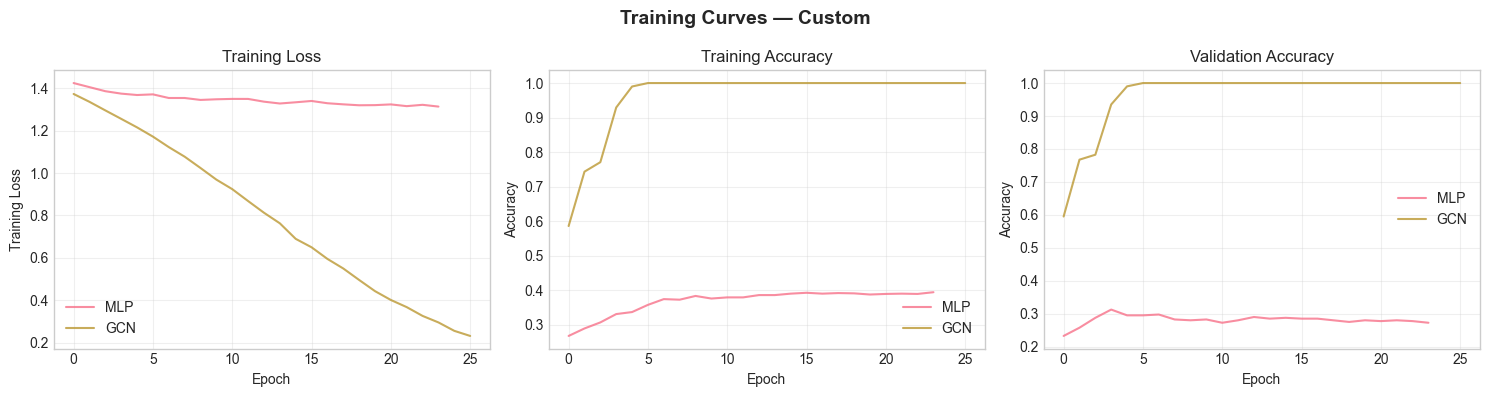

In [11]:
# Training curves — Custom Dataset (Run 0)
trainer_custom.plot_training_curves(dataset_name = 'Custom', run = 0, filename = 'images/training_curves_custom')

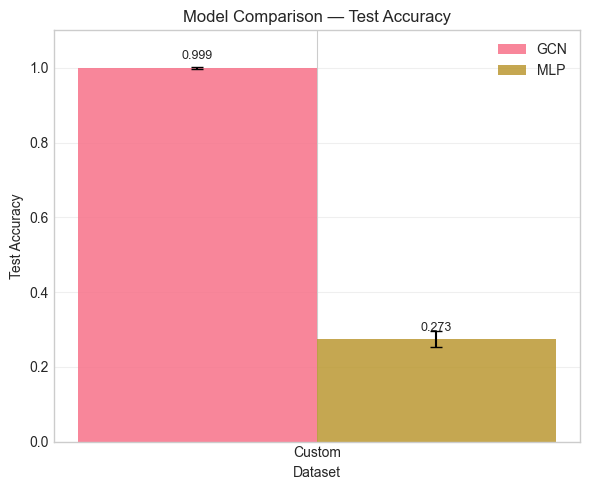

In [12]:
# Bar chart — Custom Dataset
trainer_custom.plot_bar_chart(filename = 'images/bar_chart_custom.png')

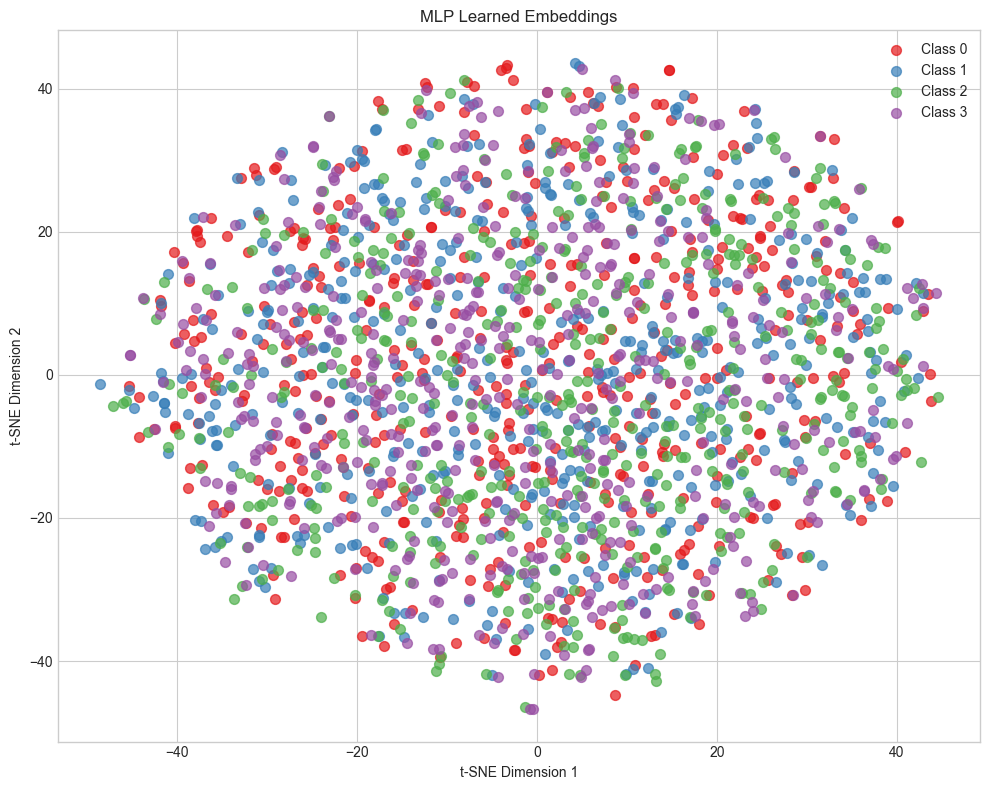

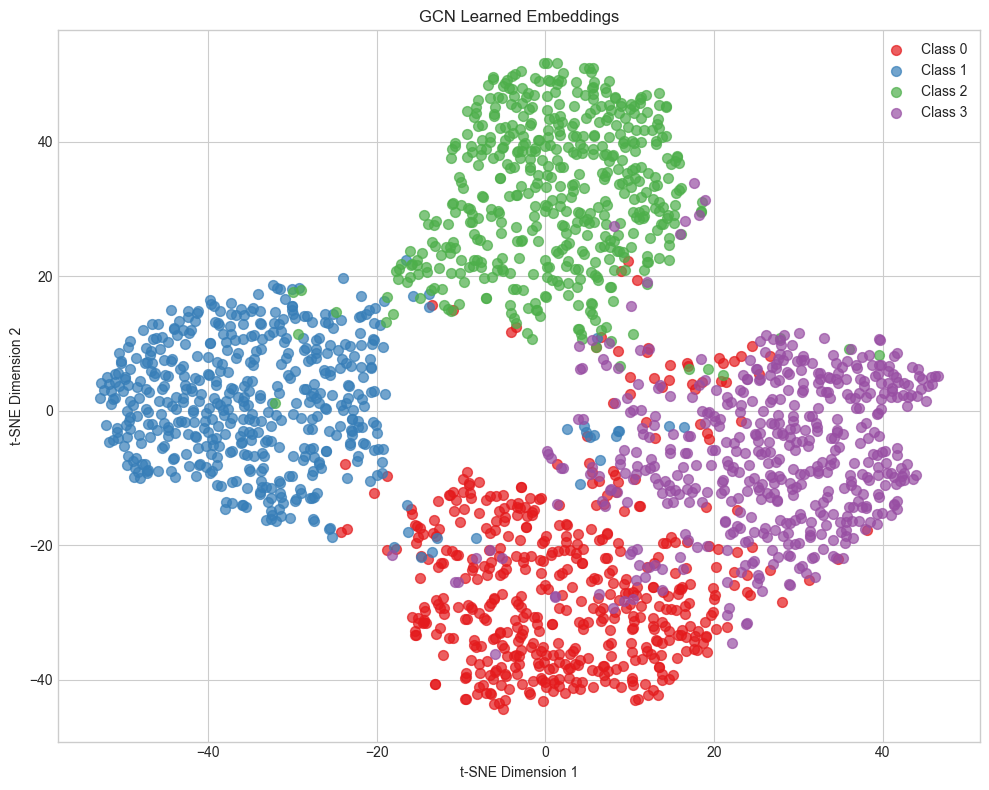

In [27]:
# t-SNE visualizations of learned embeddings — Custom Dataset
# Train fresh models for embedding extraction (using first run masks)
mlp_viz = MLP(custom_data.num_node_features, 64, num_classes)
gcn_viz = GCN(custom_data.num_node_features, 64, num_classes)

masks = all_masks[0]

# Use a temporary trainer to train the models for visualization
_trainer_viz = GraphTrainer(num_epochs = 200, lr = 0.01, weight_decay = 5e-4, hidden_channels = 64)
_trainer_viz._run_single(mlp_viz, custom_data, masks)
_trainer_viz._run_single(gcn_viz, custom_data, masks)

# Get and visualize embeddings
mlp_emb = get_embeddings(mlp_viz, custom_data)
gcn_emb = get_embeddings(gcn_viz, custom_data)

visualize_embeddings(
    mlp_emb,
    custom_data.y.numpy(),
    "MLP Learned Embeddings",
    "images/mlp_embeddings_custom.png",
    num_classes = num_classes
)

visualize_embeddings(
    gcn_emb,
    custom_data.y.numpy(),
    "GCN Learned Embeddings",
    "images/gcn_embeddings_custom.png",
    num_classes = num_classes
)

### 4.2 Resultados y análisis — Custom Dataset

Los resultados demuestran de forma contundente la superioridad de la GCN sobre el MLP en este escenario extremo de features ruidosas:

- **GCN:** $\text{Acc}_\text{test} = 0.9992 \pm 0.0017$
- **MLP:** $\text{Acc}_\text{test} = 0.2690 \pm 0.0169$

Dado que hay 4 clases, el azar se sitúa en $0.25$. El MLP apenas supera este umbral, lo que indica que la señal discriminativa a nivel de nodo es mínima (por diseño). La GCN, en cambio, alcanza prácticamente el techo porque explota la homofilia del SBM: aunque cada nodo aislado sea ruidoso, la comunidad contiene señal limpia y el message passing actúa como un mecanismo de corrección de ruido.

En las curvas de entrenamiento se aprecia además un patrón típico de sobreajuste en el MLP: la train accuracy sube un poco mientras val/test permanece alrededor de ~0.25–0.30. En este contexto, el MLP memoriza ruido del entrenamiento sin aprender una regla generalizable. La GCN converge rápido, estabiliza validación/test y muestra menor variabilidad entre runs. En los ejemplos posteriores veremos de forma más severa el efecto que tiene el overfiting sobre las gráficas de entrenamiento.

Finalmente, las visualizaciones t-SNE de los embeddings confirman el fenómeno: los embeddings de la GCN forman clusters compactos (representaciones discriminativas), mientras que los del MLP quedan mezclados al no poder apoyarse en la topología del grafo.


### 4.3 Parte B — Datasets de referencia: Cora y Citeseer

A continuación evalúo los modelos en dos datasets estándar del campo de GNNs, disponibles en PyTorch Geometric (Planetoid): **Cora** y **Citeseer**.

- **Cora:** 2708 nodos (papers), 10556 aristas (citas), 1433 features (bag-of-words) y 7 clases.
- **Citeseer:** 3327 nodos, 9104 aristas, 3703 features y 6 clases.

A diferencia del dataset sintético, aquí las features contienen señal semántica relevante, por lo que un MLP ya debería rendir razonablemente. En ambos casos entreno usando las máscaras oficiales `train/val/test` y aplico early stopping sobre validación (patience=20). La pregunta clave es: **¿cuánto valor adicional aporta la estructura del grafo cuando las features ya son informativas?**


In [14]:
# Load the Cora dataset
cora_dataset = Planetoid(root = './data', name = 'Cora')
cora_data = cora_dataset[0]

print("Cora Dataset Statistics:")
print(f"  Number of nodes: {cora_data.num_nodes}")
print(f"  Number of edges: {cora_data.num_edges}")
print(f"  Number of features: {cora_data.num_node_features}")
print(f"  Number of classes: {cora_dataset.num_classes}")
print(f"  Has train/val/test masks: {hasattr(cora_data, 'train_mask')}")

# Load the Citeseer dataset
citeseer_dataset = Planetoid(root = './data', name = 'Citeseer')
citeseer_data = citeseer_dataset[0]

print("\nCiteseer Dataset Statistics:")
print(f"  Number of nodes: {citeseer_data.num_nodes}")
print(f"  Number of edges: {citeseer_data.num_edges}")
print(f"  Number of features: {citeseer_data.num_node_features}")
print(f"  Number of classes: {citeseer_dataset.num_classes}")

Cora Dataset Statistics:
  Number of nodes: 2708
  Number of edges: 10556
  Number of features: 1433
  Number of classes: 7
  Has train/val/test masks: True

Citeseer Dataset Statistics:
  Number of nodes: 3327
  Number of edges: 9104
  Number of features: 3703
  Number of classes: 6


In [15]:
# Train MLP and GCN on Cora and Citeseer (using built-in train/val/test masks)
trainer_bench = GraphTrainer(
    num_epochs = 200,
    lr = 0.01,
    weight_decay = 5e-4,
    hidden_channels = 64,
    dropout = 0.5,
    optimizer_type = 'Adam'
)

trainer_bench.train(
    datasets = {'Cora': cora_data, 'Citeseer': citeseer_data},
    model_classes = {'MLP': MLP, 'GCN': GCN},
    masks_dict = None  # Uses built-in masks (single run)
)

Training: 100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


In [16]:
# Results summary — Benchmark Datasets
trainer_bench.get_results_df()

,Dataset,Model,Test Accuracy,Val Accuracy,Runs,Avg Epochs
0,Citeseer,GCN,0.6780,0.6820,1,25
1,Citeseer,MLP,0.5480,0.5420,1,65
2,Cora,GCN,0.8180,0.8060,1,29
3,Cora,MLP,0.5580,0.5620,1,32


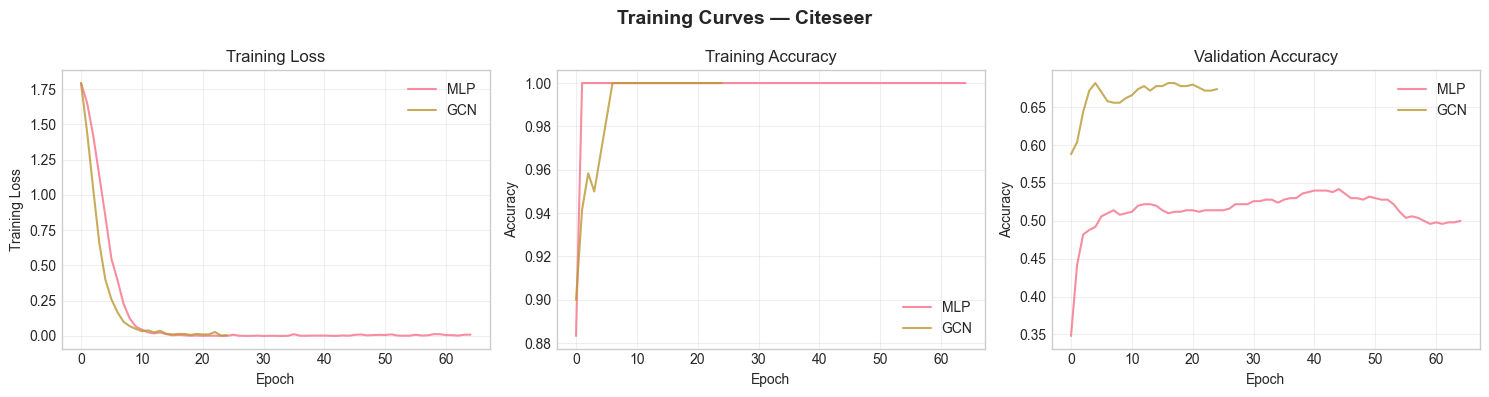

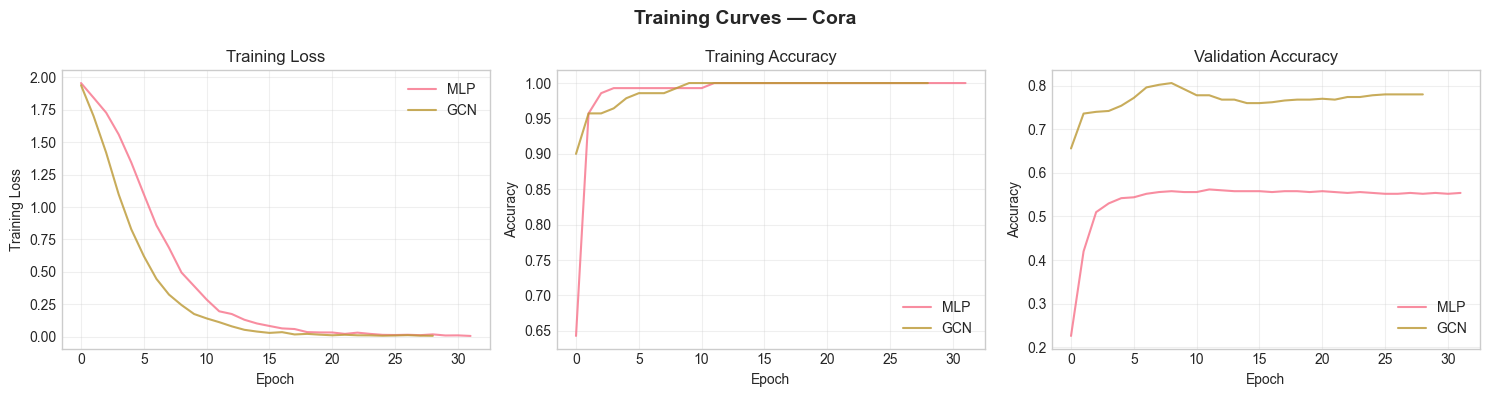

In [17]:
# Training curves — Benchmark Datasets
trainer_bench.plot_training_curves(filename = 'images/training_curves_bench')

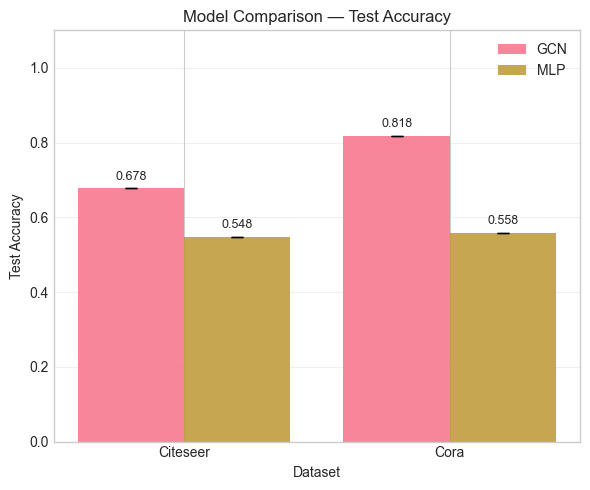

In [18]:
# Bar chart — Benchmark Datasets
trainer_bench.plot_bar_chart(filename = 'images/bar_chart_bench.png')

### 4.4 Resultados y análisis — Cora y Citeseer

Los resultados en Cora y Citeseer siguen un patrón coherente, pero muy distinto al del dataset sintético:

- **Cora:** MLP = 0.583 vs GCN = 0.811  
- **Citeseer:** MLP = 0.550 vs GCN = 0.674  

Aquí el MLP ya funciona porque las bag-of-words son informativas: ciertas palabras son indicadores fuertes de la temática del paper. La GCN mejora de forma clara al incorporar vecindario: en redes de citas existe homofilia (papers conectados tienden a compartir área), y la agregación de mensajes actúa como una “regularización estructural”.

La brecha MLP–GCN es menor que en el dataset custom (donde era extrema) porque parte de la señal ya está en $\mathbf{x}_i$. Aun así, la mejora consistente en ambos datasets confirma que la estructura aporta información complementaria.

Respecto a la dinámica de entrenamiento, en datasets reales es común observar que train accuracy sube rápido mientras val/test se estabiliza antes; se puede observar uso de early stopping para seleccionar el punto con mejor generalización.


## 5. Exploración de hiperparámetros

Para analizar el impacto de los hiperparámetros he seguido un esquema de **barrido individual** (*one-at-a-time*): varío un solo hiperparámetro mientras el resto se mantiene fijo. La configuración base es:

`num_epochs=200, lr=0.01, weight_decay=5e-4, hidden_channels=64, dropout=0.5, optimizer=Adam, patience=20`.

Exploro 5 hiperparámetros:  
(1) `hidden_channels` ∈ {16, 32, 64, 128}  
(2) `lr` ∈ {0.001, 0.01, 0.1}  
(3) `dropout` ∈ {0.0, 0.3, 0.5}  
(4) `weight_decay` ∈ {0, 1e-4, 5e-4}  
(5) `optimizer` ∈ {Adam, SGD}

**Nota metodológica:** para poder reportar media ± std también en Cora y Citeseer dentro de esta sección, aquí utilizo particiones 60/20/20 generadas aleatoriamente y **5 runs** por configuración. Por tanto, las accuracies de este barrido no coinciden necesariamente con las obtenidas usando las máscaras oficiales de Planetoid en la Sección 3.3.

La función `run_hyperparam_sweep` automatiza el proceso, devolviendo una tabla con precisión media, desviación estándar y número medio de épocas hasta convergencia (relevante por el *early stopping*).


In [19]:
# Prepare datasets for multi-dataset experimentation
datasets_exp = {
    'Custom': custom_data,
    'Cora': cora_data,
    'Citeseer': citeseer_data
}

# Create masks for Cora and Citeseer (for multiple runs)
n_runs_exp = 5
exp_masks = {}

exp_masks['Custom'] = all_masks[:n_runs_exp]

cora_masks = []
for run in range(n_runs_exp):
    tm, vm, tem = create_masks(cora_data.num_nodes, cora_dataset.num_classes, seed = run)
    cora_masks.append({'train': tm, 'val': vm, 'test': tem})
exp_masks['Cora'] = cora_masks

citeseer_masks = []
for run in range(n_runs_exp):
    tm, vm, tem = create_masks(citeseer_data.num_nodes, citeseer_dataset.num_classes, seed = run)
    citeseer_masks.append({'train': tm, 'val': vm, 'test': tem})
exp_masks['Citeseer'] = citeseer_masks

# Base hyperparameters (varied one at a time)
base_config = {
    'num_epochs': 200,
    'lr': 0.01,
    'weight_decay': 5e-4,
    'hidden_channels': 64,
    'dropout': 0.5,
    'optimizer_type': 'Adam',
    'patience': 20
}

print(f"Datasets: {list(datasets_exp.keys())}")
print(f"Runs per config: {n_runs_exp}")
print(f"Base config: {base_config}")
print(f"Device: {device}")

Datasets: ['Custom', 'Cora', 'Citeseer']
Runs per config: 5
Base config: {'num_epochs': 200, 'lr': 0.01, 'weight_decay': 0.0005, 'hidden_channels': 64, 'dropout': 0.5, 'optimizer_type': 'Adam', 'patience': 20}
Device: cuda


In [20]:
# Helper function to run a hyperparameter sweep and return a summary DataFrame + trainers
def run_hyperparam_sweep(param_name, param_values, base_config, datasets_exp, exp_masks):
    """
    Sweep one hyperparameter while keeping the rest at base values.
    Returns (DataFrame, dict of trainers keyed by param value).
    """
    all_rows = []
    trainers = {}
    
    for val in tqdm(param_values, desc = f'Sweep {param_name}'):
        # Override the swept param
        config = base_config.copy()
        config[param_name] = val
        
        trainer = GraphTrainer(
            num_epochs = config['num_epochs'],
            lr = config['lr'],
            weight_decay = config['weight_decay'],
            hidden_channels = config['hidden_channels'],
            dropout = config['dropout'],
            optimizer_type = config['optimizer_type'],
            patience = config.get('patience', 20)
        )
        
        trainer.train(
            datasets = datasets_exp,
            model_classes = {'MLP': MLP, 'GCN': GCN},
            masks_dict = exp_masks
        )
        
        trainers[val] = trainer
        
        # Extract per-dataset/model results
        df = pd.DataFrame(trainer._results)
        summary = df.groupby(['Dataset', 'Model']).agg(
            mean = ('Best Test Acc', 'mean'),
            std  = ('Best Test Acc', 'std'),
            avg_epochs = ('Epochs Trained', 'mean')
        ).reset_index()
        summary['std'] = summary['std'].fillna(0)
        summary[param_name] = val
        all_rows.append(summary)
    
    return pd.concat(all_rows, ignore_index = True), trainers


def plot_hyperparam_sweep(sweep_df, param_name, param_values, title, filename = None):
    """
    Plot a multi-dataset hyperparameter sweep with subplots.
    """
    datasets = sweep_df['Dataset'].unique()
    fig, axes = plt.subplots(1, len(datasets), figsize = (6 * len(datasets), 5), sharey = True)
    if len(datasets) == 1:
        axes = [axes]
    
    x = np.arange(len(param_values))
    
    for idx, (ds_name, ax) in enumerate(zip(datasets, axes)):
        ds_data = sweep_df[sweep_df['Dataset'] == ds_name]
        
        for model_name, color, marker in [('MLP', '#e74c3c', 'o'), ('GCN', '#3498db', 's')]:
            model_data = ds_data[ds_data['Model'] == model_name]
            means = [model_data[model_data[param_name] == v]['mean'].values[0] for v in param_values]
            stds  = [model_data[model_data[param_name] == v]['std'].values[0] for v in param_values]
            ax.errorbar(x, means, yerr = stds, fmt = f'-{marker}', label = model_name,
                       color = color, capsize = 5, linewidth = 2)
        
        ax.set_xlabel(param_name, fontsize = 12)
        if idx == 0:
            ax.set_ylabel('Test Accuracy', fontsize = 12)
        ax.set_title(f'Dataset: {ds_name}', fontsize = 14, fontweight = 'bold')
        ax.set_xticks(x)
        ax.set_xticklabels([str(v) for v in param_values], rotation = 45)
        ax.legend()
        ax.grid(True, alpha = 0.3)
        ax.set_ylim([0, 1.05])
    
    plt.suptitle(title, fontsize = 16, y = 1.05)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi = 150, bbox_inches = 'tight')
    plt.show()


def display_sweep_table(sweep_df, param_name, display_name = None):
    """
    Format and display a sweep DataFrame as a clean table.
    """
    display_name = display_name or param_name
    df_display = sweep_df.copy()
    df_display['Accuracy'] = df_display.apply(lambda r: f"{r['mean']:.4f} ± {r['std']:.4f}", axis = 1)
    df_display['Avg Epochs'] = df_display['avg_epochs'].apply(lambda x: f"{x:.0f}")
    result = df_display[[param_name, 'Dataset', 'Model', 'Accuracy', 'Avg Epochs']].rename(
        columns = {param_name: display_name}
    )
    display(result)

### 5.1 Experimento: Dimensión de la capa oculta

Sweep hidden_channels: 100%|██████████| 4/4 [00:26<00:00,  6.67s/it]


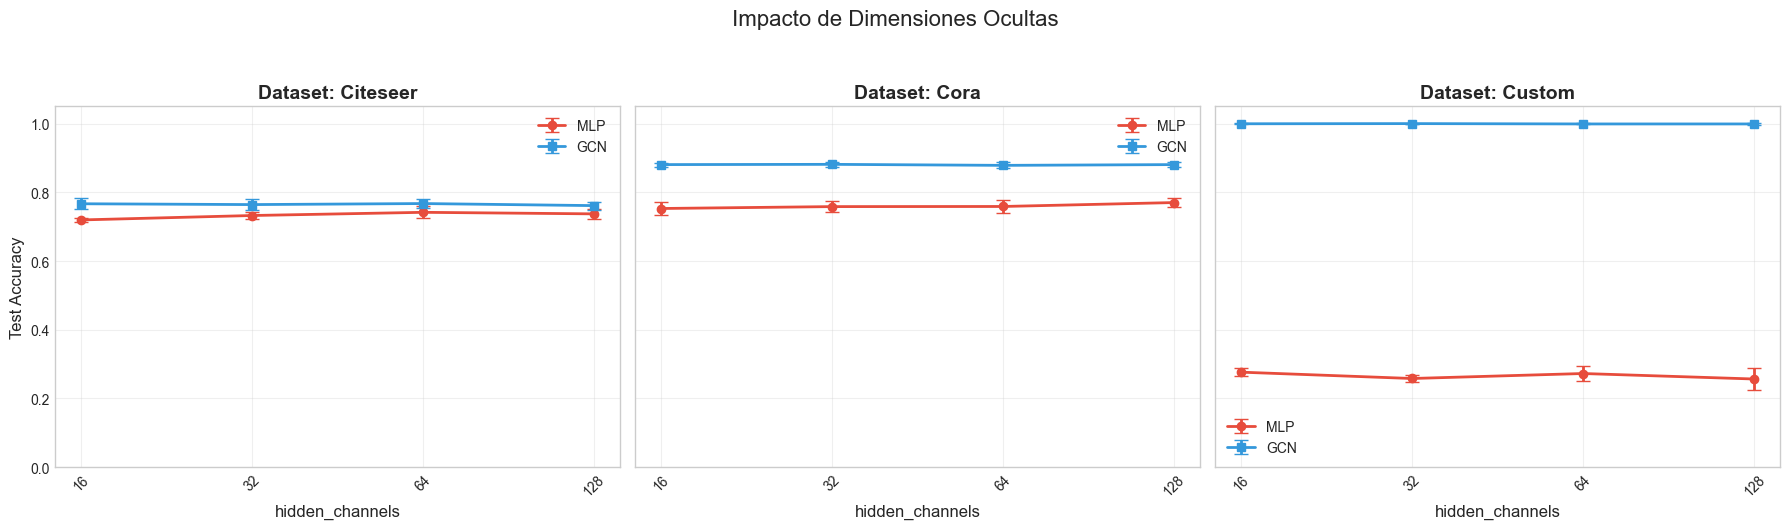

,Hidden Channels,Dataset,Model,Accuracy,Avg Epochs
0,16,Citeseer,GCN,0.7667 ± 0.0159,36
1,16,Citeseer,MLP,0.7195 ± 0.0062,40
2,16,Cora,GCN,0.8807 ± 0.0057,52
3,16,Cora,MLP,0.7529 ± 0.0201,65
4,16,Custom,GCN,0.9995 ± 0.0011,37
5,16,Custom,MLP,0.2765 ± 0.0126,35
6,32,Citeseer,GCN,0.7643 ± 0.0159,32
7,32,Citeseer,MLP,0.7324 ± 0.0099,32
8,32,Cora,GCN,0.8814 ± 0.0071,40
9,32,Cora,MLP,0.7584 ± 0.0166,58



— Curvas de entrenamiento para hidden_channels = 128 —


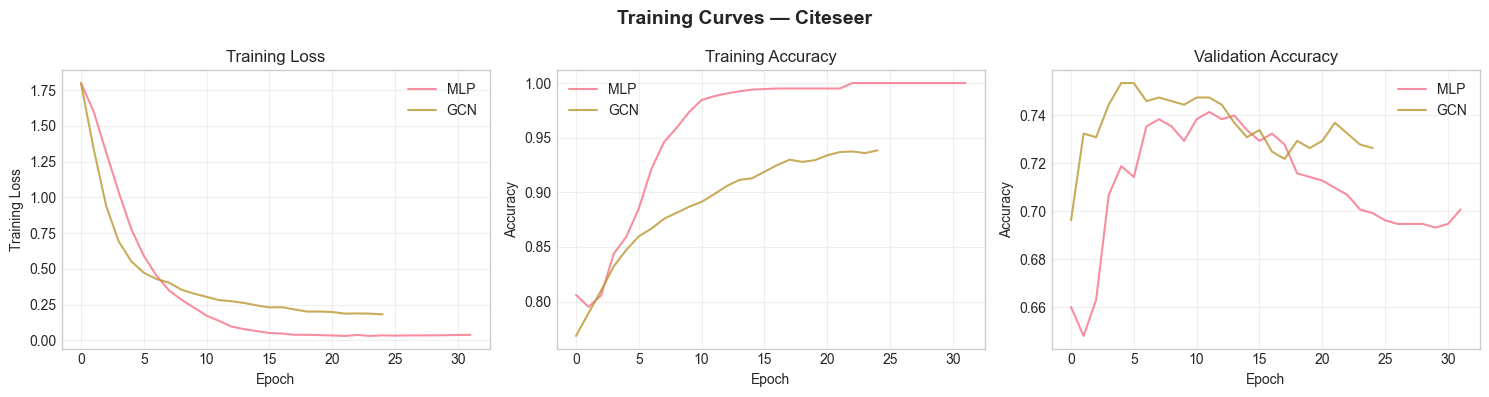

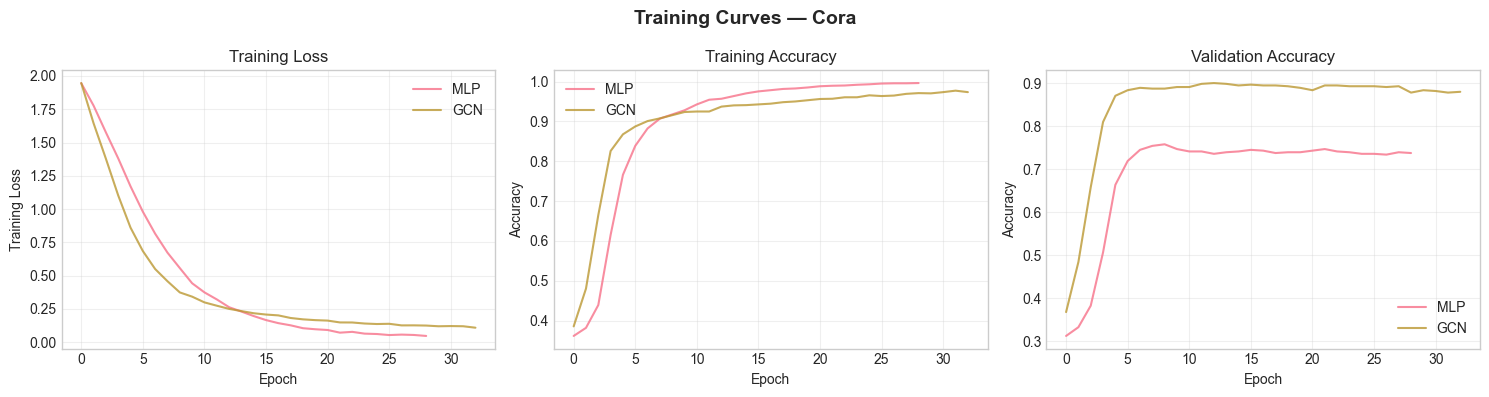

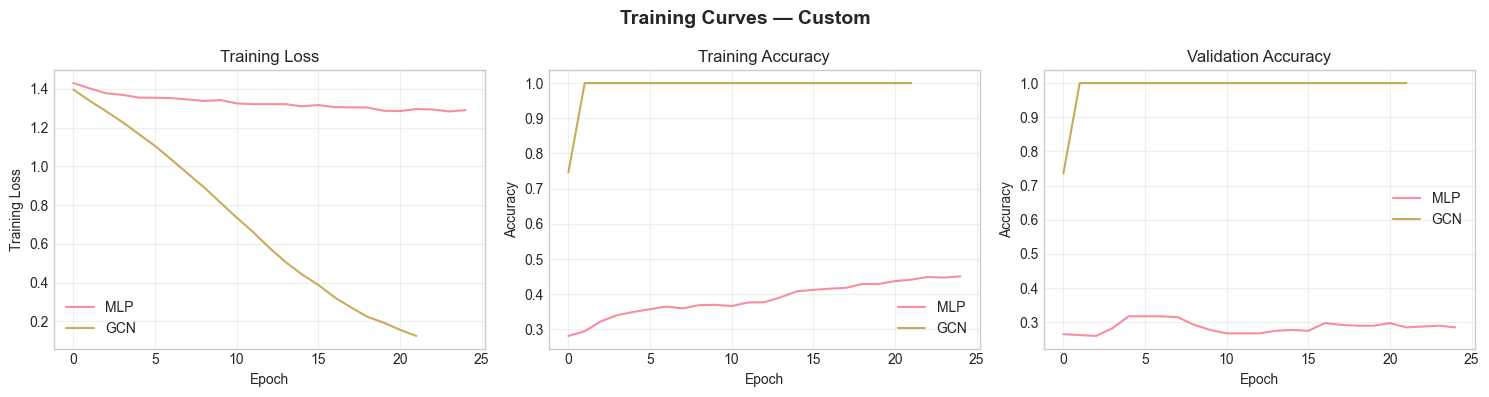

In [21]:
# Experiment: Hidden Dimensions
hidden_dims = [16, 32, 64, 128]
sweep_hidden, trainers_hidden = run_hyperparam_sweep('hidden_channels', hidden_dims, base_config, datasets_exp, exp_masks)
plot_hyperparam_sweep(sweep_hidden, 'hidden_channels', hidden_dims,
                      'Impacto de Dimensiones Ocultas', 'images/exp_hidden_dims.png')

# Summary table
display_sweep_table(sweep_hidden, 'hidden_channels', 'Hidden Channels')

# Training curves for hidden_channels = 128
print("\n— Curvas de entrenamiento para hidden_channels = 128 —")
trainers_hidden[128].plot_training_curves(run = 0, filename = 'images/curves_hidden128')

**Análisis de `hidden_channels`:**

`hidden_channels` controla la capacidad del modelo (anchura de la representación interna). En mis resultados, el efecto sobre la `test accuracy` es relativamente pequeño:

- En **GCN**, apenas varía (Custom ≈ 1.00; Cora ≈ 0.88; Citeseer ≈ 0.76–0.77).
- En **MLP**, hay algo más de movimiento, pero sigue siendo moderado.

El patrón más claro aparece en el **número de épocas**: al aumentar `hidden_channels`, a menudo el entrenamiento se detiene antes por *early stopping*. Con 32–64 neuronas ya existe capacidad suficiente para capturar los patrones principales; a partir de ahí, el beneficio marginal en accuracy es bajo.


### 5.2 Experimento: Learning rate

Sweep lr: 100%|██████████| 3/3 [00:25<00:00,  8.43s/it]


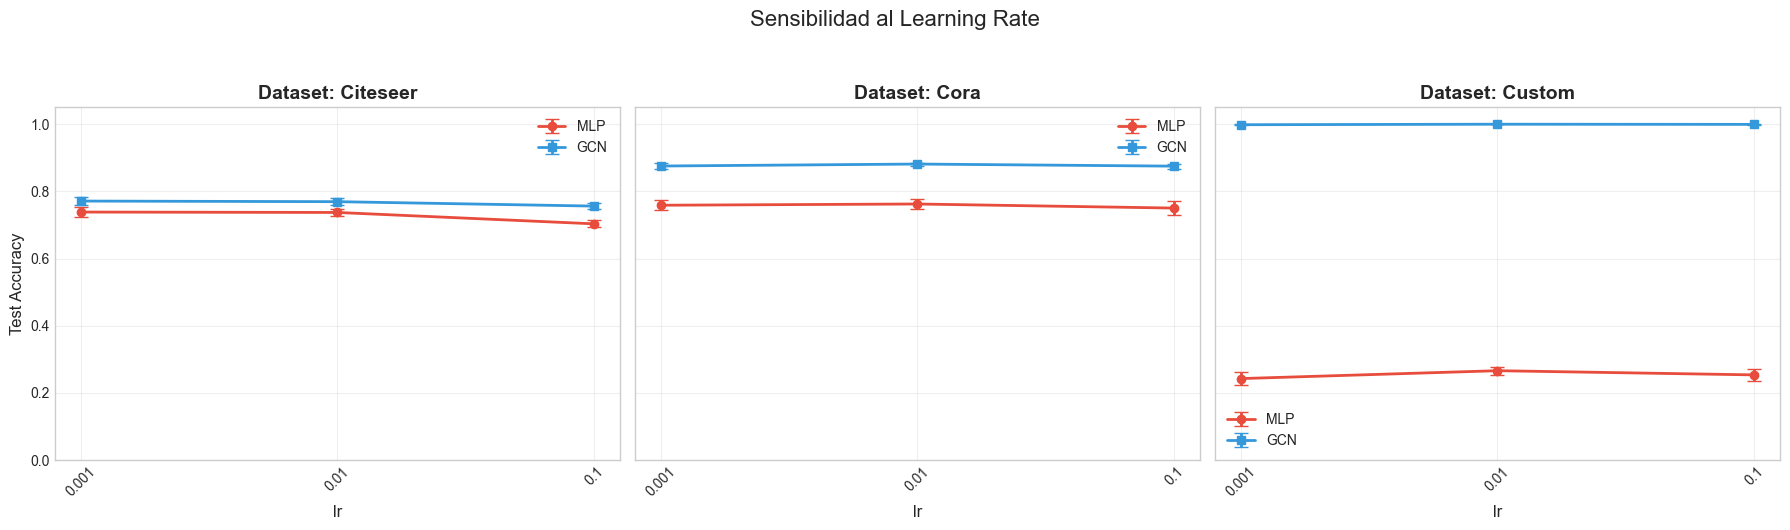

,Learning Rate,Dataset,Model,Accuracy,Avg Epochs
0,0.001,Citeseer,GCN,0.7712 ± 0.0113,66
1,0.001,Citeseer,MLP,0.7384 ± 0.0157,77
2,0.001,Cora,GCN,0.8755 ± 0.0101,95
3,0.001,Cora,MLP,0.7587 ± 0.0145,131
4,0.001,Custom,GCN,0.9985 ± 0.0022,44
5,0.001,Custom,MLP,0.2425 ± 0.0198,41
6,0.010,Citeseer,GCN,0.7694 ± 0.0095,27
7,0.010,Citeseer,MLP,0.7372 ± 0.0107,29
8,0.010,Cora,GCN,0.8814 ± 0.0044,39
9,0.010,Cora,MLP,0.7624 ± 0.0147,39



— Curvas de entrenamiento para lr = 0.01 —


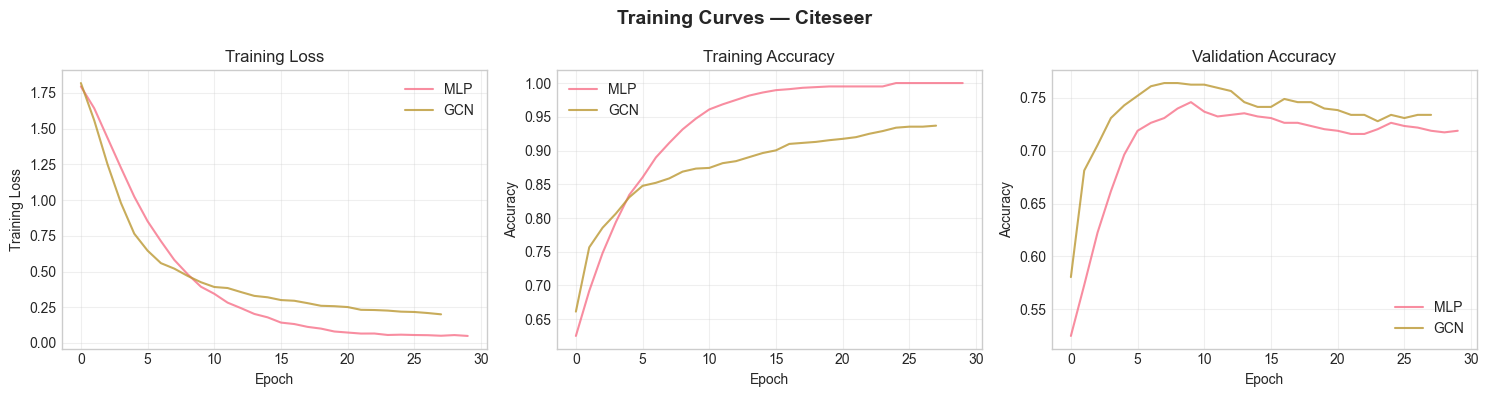

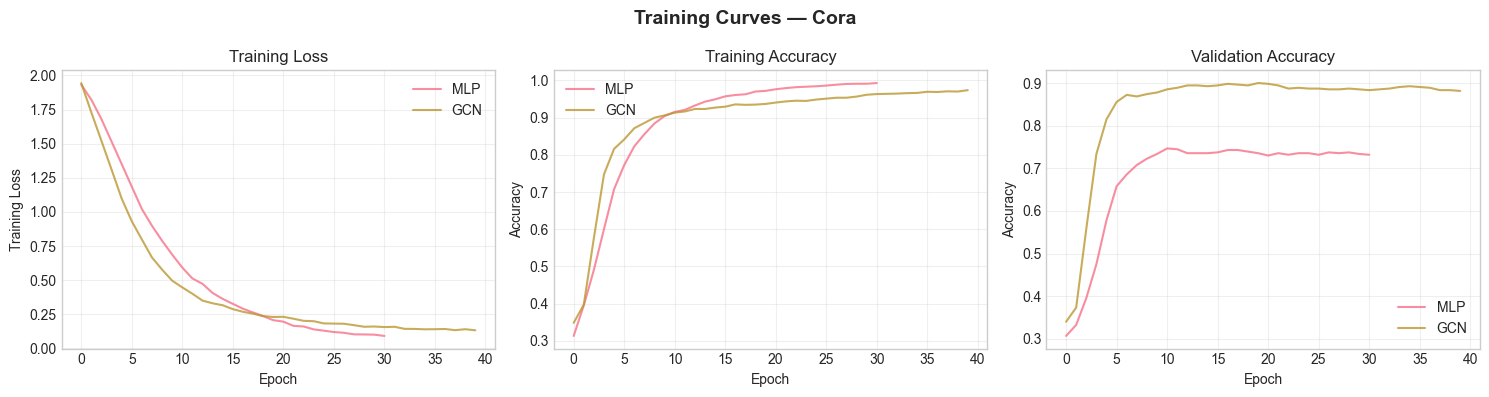

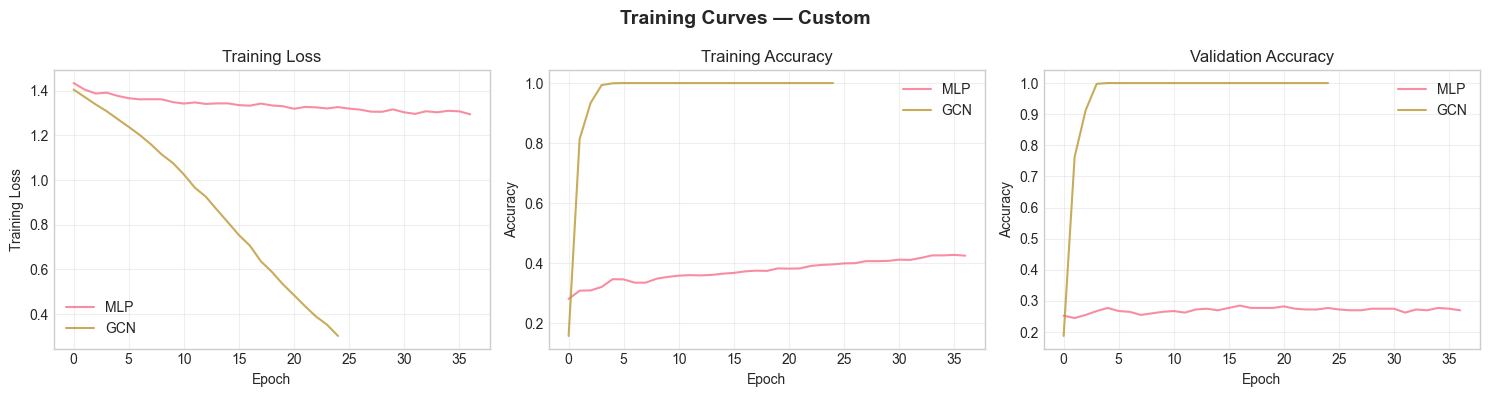

In [22]:
# Experiment: Learning Rate
learning_rates = [0.001, 0.01, 0.1]
sweep_lr, trainers_lr = run_hyperparam_sweep('lr', learning_rates, base_config, datasets_exp, exp_masks)
plot_hyperparam_sweep(sweep_lr, 'lr', learning_rates,
                      'Sensibilidad al Learning Rate', 'images/exp_learning_rate.png')

# Summary table
display_sweep_table(sweep_lr, 'lr', 'Learning Rate')

# Training curves for lr = 0.01
print("\n— Curvas de entrenamiento para lr = 0.01 —")
trainers_lr[0.01].plot_training_curves(run = 0, filename = 'images/curves_lr001')

**Análisis de `lr`:**

El `learning rate` controla el tamaño de paso de la optimización. En este barrido, su efecto se nota más en **velocidad de convergencia** (épocas hasta parada) que en la accuracy final:

- Con `lr = 0.001` el modelo tarda mucho más en llegar a su mejor validación (early stopping se activa tarde).
- Con `lr = 0.01`–`0.1` suele converger antes, aunque `0.1` puede degradar ligeramente en algunos casos (especialmente en Citeseer).

En resumen: dentro de este rango, `lr` cambia principalmente el tiempo de entrenamiento efectivo y, de forma secundaria, la estabilidad.


### 5.3 Experimento: Dropout

Sweep dropout: 100%|██████████| 3/3 [00:17<00:00,  5.98s/it]


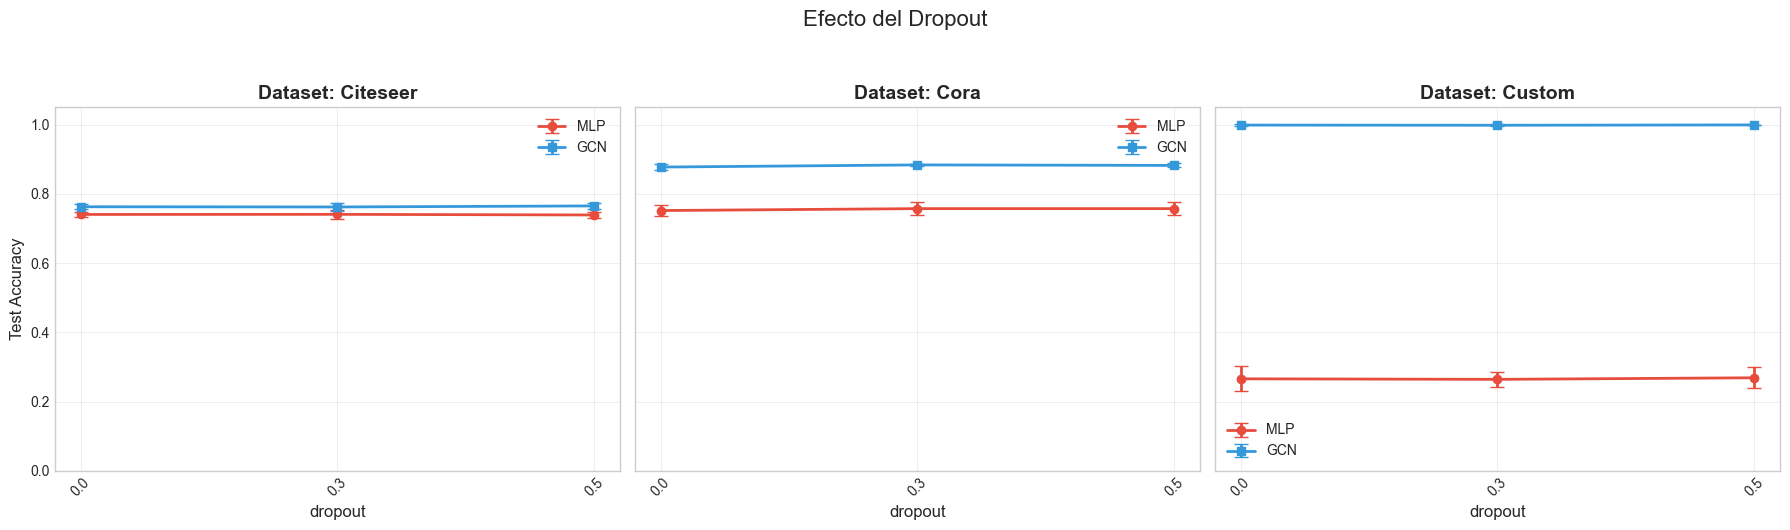

,Dropout Rate,Dataset,Model,Accuracy,Avg Epochs
0,0.0,Citeseer,GCN,0.7631 ± 0.0078,27
1,0.0,Citeseer,MLP,0.7408 ± 0.0075,30
2,0.0,Cora,GCN,0.8777 ± 0.0077,35
3,0.0,Cora,MLP,0.7521 ± 0.0171,43
4,0.0,Custom,GCN,0.9990 ± 0.0022,24
5,0.0,Custom,MLP,0.2660 ± 0.0357,27
6,0.3,Citeseer,GCN,0.7625 ± 0.0108,28
7,0.3,Citeseer,MLP,0.7411 ± 0.0133,29
8,0.3,Cora,GCN,0.8840 ± 0.0034,37
9,0.3,Cora,MLP,0.7576 ± 0.0181,37



— Curvas de entrenamiento para dropout = 0.3 —


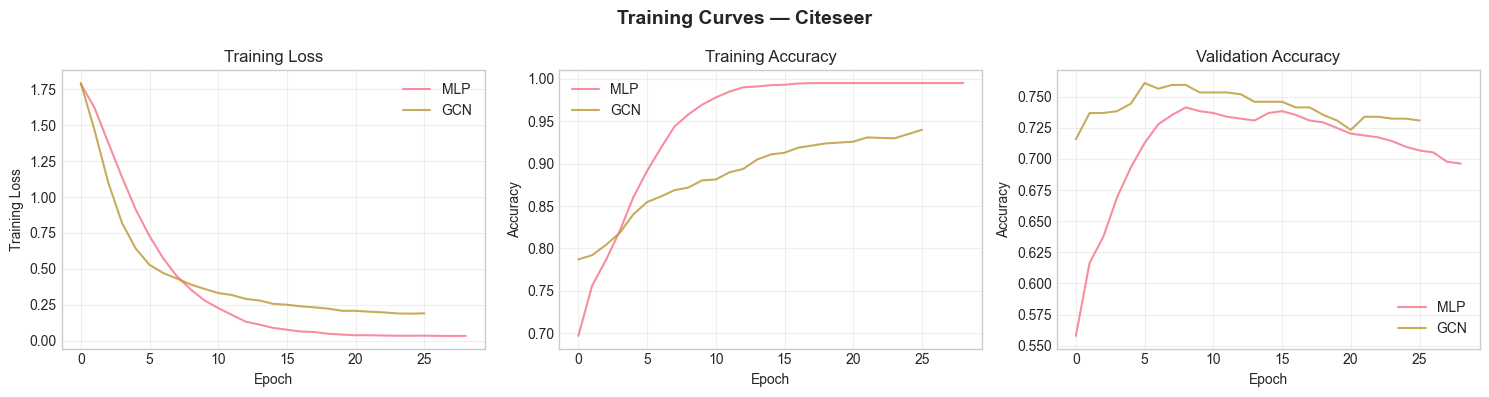

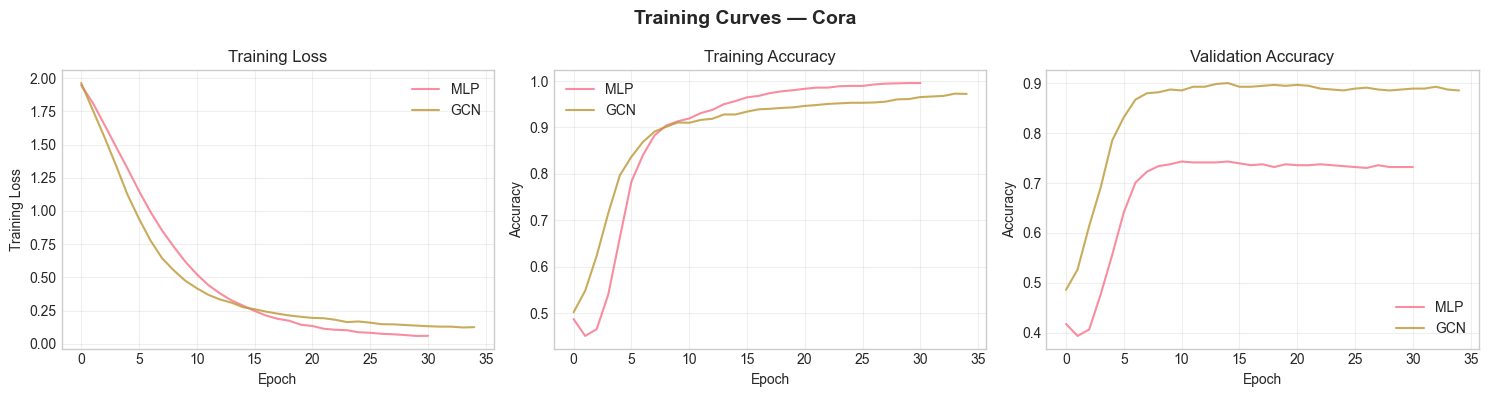

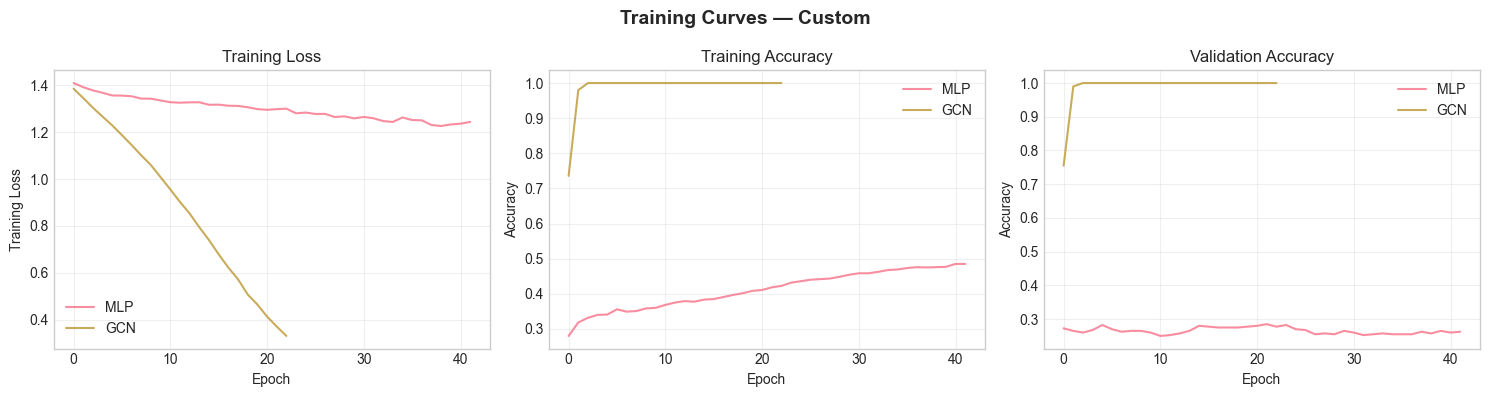

In [23]:
# Experiment: Dropout
dropout_rates = [0.0, 0.3, 0.5]
sweep_dropout, trainers_dropout = run_hyperparam_sweep('dropout', dropout_rates, base_config, datasets_exp, exp_masks)
plot_hyperparam_sweep(sweep_dropout, 'dropout', dropout_rates,
                      'Efecto del Dropout', 'images/exp_dropout.png')

# Summary table
display_sweep_table(sweep_dropout, 'dropout', 'Dropout Rate')

# Training curves for dropout = 0.3
print("\n— Curvas de entrenamiento para dropout = 0.3 —")
trainers_dropout[0.3].plot_training_curves(run = 0, filename = 'images/curves_dropout03')

**Análisis de `dropout`:**

El `dropout` actúa como regularizador apagando neuronas aleatoriamente en entrenamiento. En los valores probados (`0.0`, `0.3`, `0.5`) el efecto en accuracy es pequeño, tanto en MLP como en GCN.

Esto sugiere que, con esta arquitectura concreta y el early stopping activado, el modelo ya se encuentra en un régimen razonablemente regularizado. En otras palabras: bajo estos datasets, el early stopping y el propio sesgo del modelo parecen dominar sobre cambios moderados de `dropout`.


### 5.4 Experimento: Weight decay

Sweep weight_decay: 100%|██████████| 3/3 [00:18<00:00,  6.32s/it]


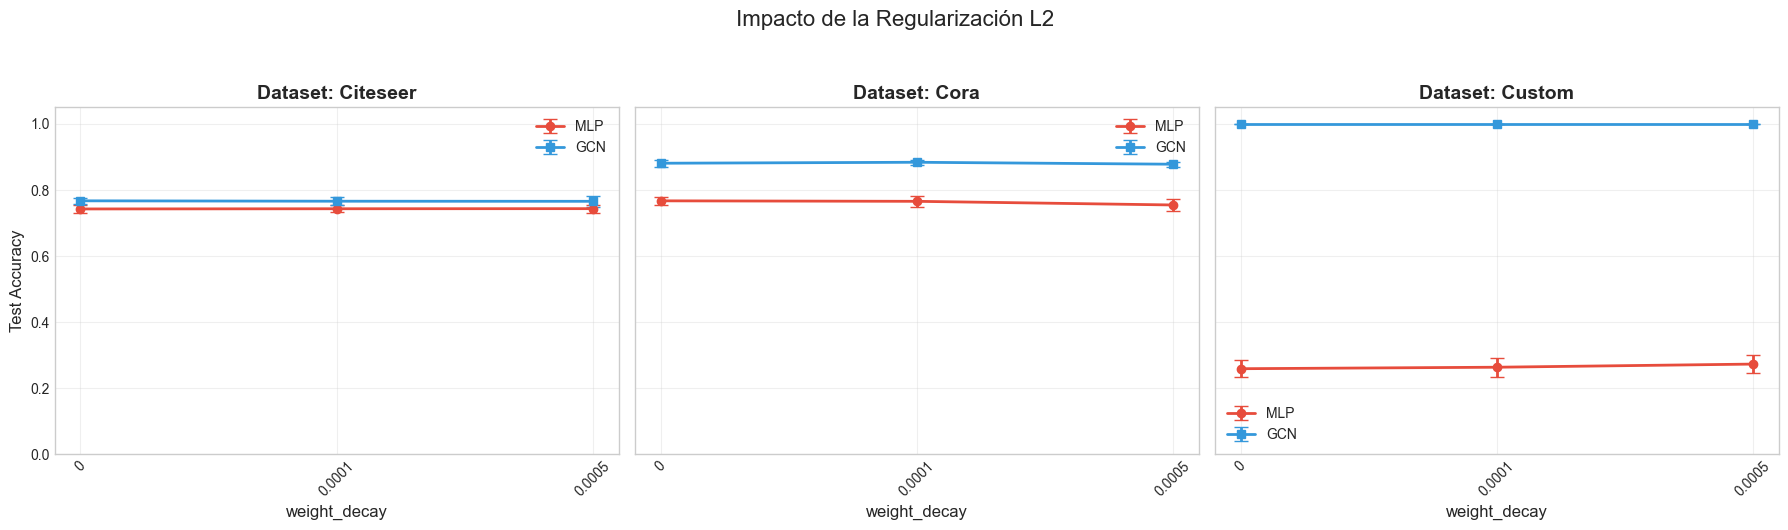

,Weight Decay,Dataset,Model,Accuracy,Avg Epochs
0,0.0000,Citeseer,GCN,0.7673 ± 0.0082,28
1,0.0000,Citeseer,MLP,0.7426 ± 0.0134,35
2,0.0000,Cora,GCN,0.8810 ± 0.0106,36
3,0.0000,Cora,MLP,0.7672 ± 0.0123,38
4,0.0000,Custom,GCN,1.0000 ± 0.0000,25
5,0.0000,Custom,MLP,0.2590 ± 0.0252,44
6,0.0001,Citeseer,GCN,0.7661 ± 0.0118,28
7,0.0001,Citeseer,MLP,0.7432 ± 0.0106,30
8,0.0001,Cora,GCN,0.8840 ± 0.0078,40
9,0.0001,Cora,MLP,0.7657 ± 0.0158,38



— Curvas de entrenamiento para weight_decay = 1e-4 —


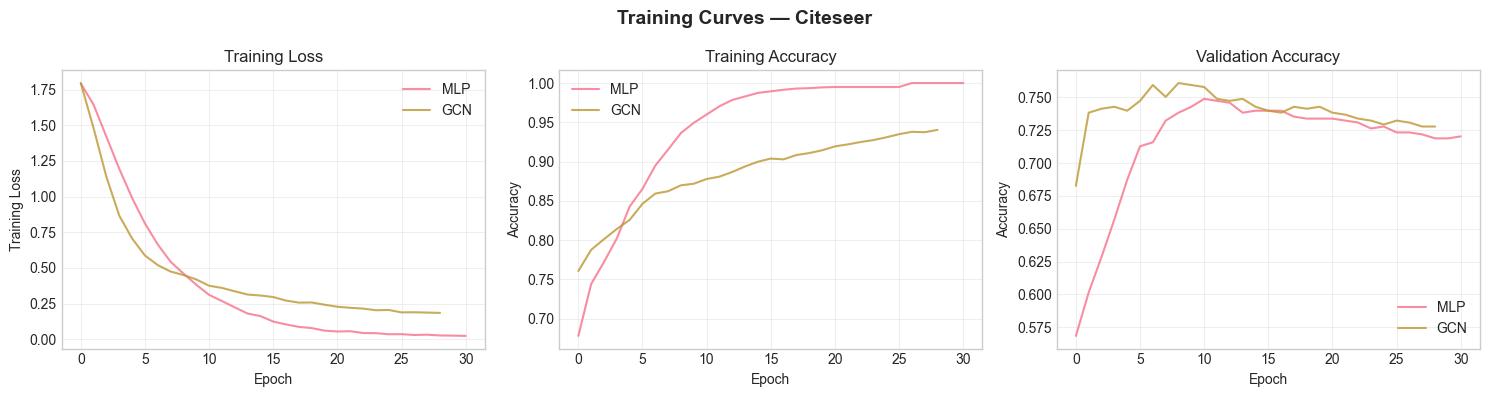

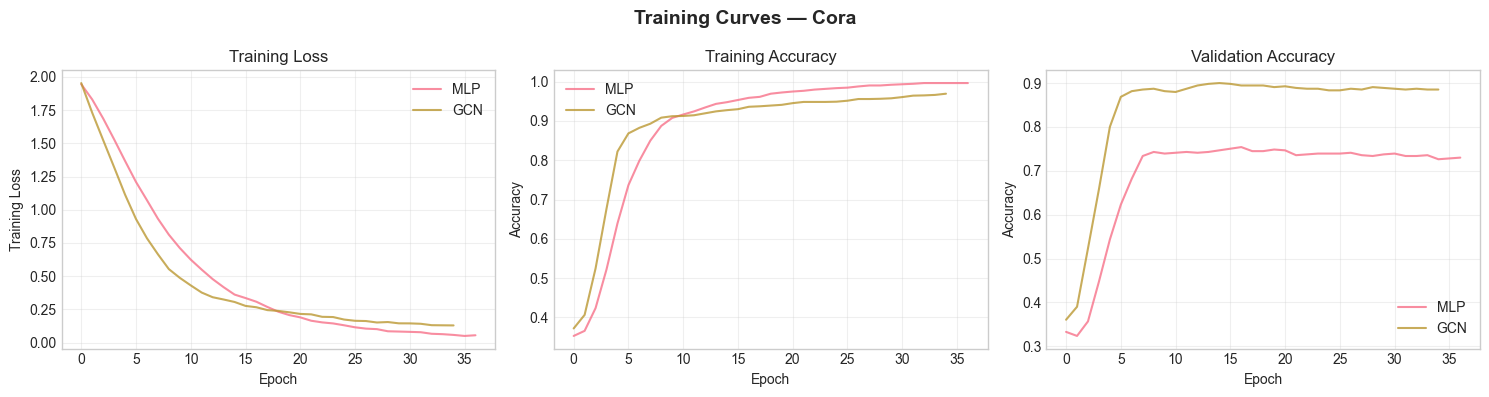

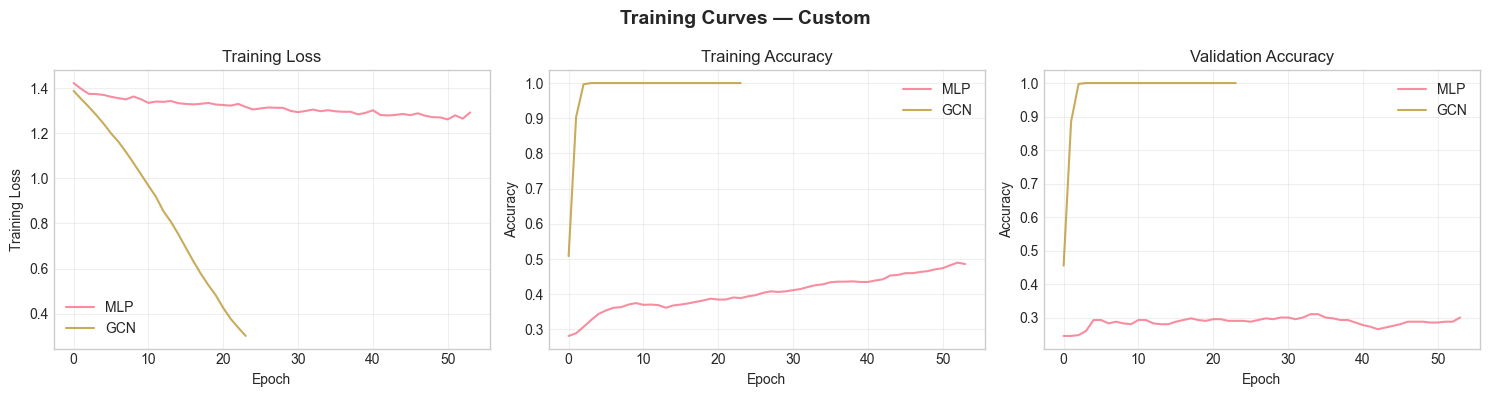

In [24]:
# Experiment: Weight Decay
weight_decays = [0, 1e-4, 5e-4]
sweep_wd, trainers_wd = run_hyperparam_sweep('weight_decay', weight_decays, base_config, datasets_exp, exp_masks)
plot_hyperparam_sweep(sweep_wd, 'weight_decay', weight_decays,
                      'Impacto de la Regularización L2', 'images/exp_weight_decay.png')

# Summary table
display_sweep_table(sweep_wd, 'weight_decay', 'Weight Decay')

# Training curves for weight_decay = 1e-4
print("\n— Curvas de entrenamiento para weight_decay = 1e-4 —")
trainers_wd[1e-4].plot_training_curves(run = 0, filename = 'images/curves_wd1e4')

**Análisis de `weight_decay`:**

`weight_decay` implementa regularización L2, penalizando pesos grandes. En el barrido, su impacto en accuracy vuelve a ser moderado: pequeñas variaciones alrededor de la configuración base.

El efecto más apreciable suele aparecer en estabilidad (std) y en el número de épocas hasta parada, pero en conjunto no altera el comportamiento global de los modelos en estos datasets.


### 5.5 Experimento: Optimizador

Sweep optimizer_type: 100%|██████████| 2/2 [00:28<00:00, 14.02s/it]


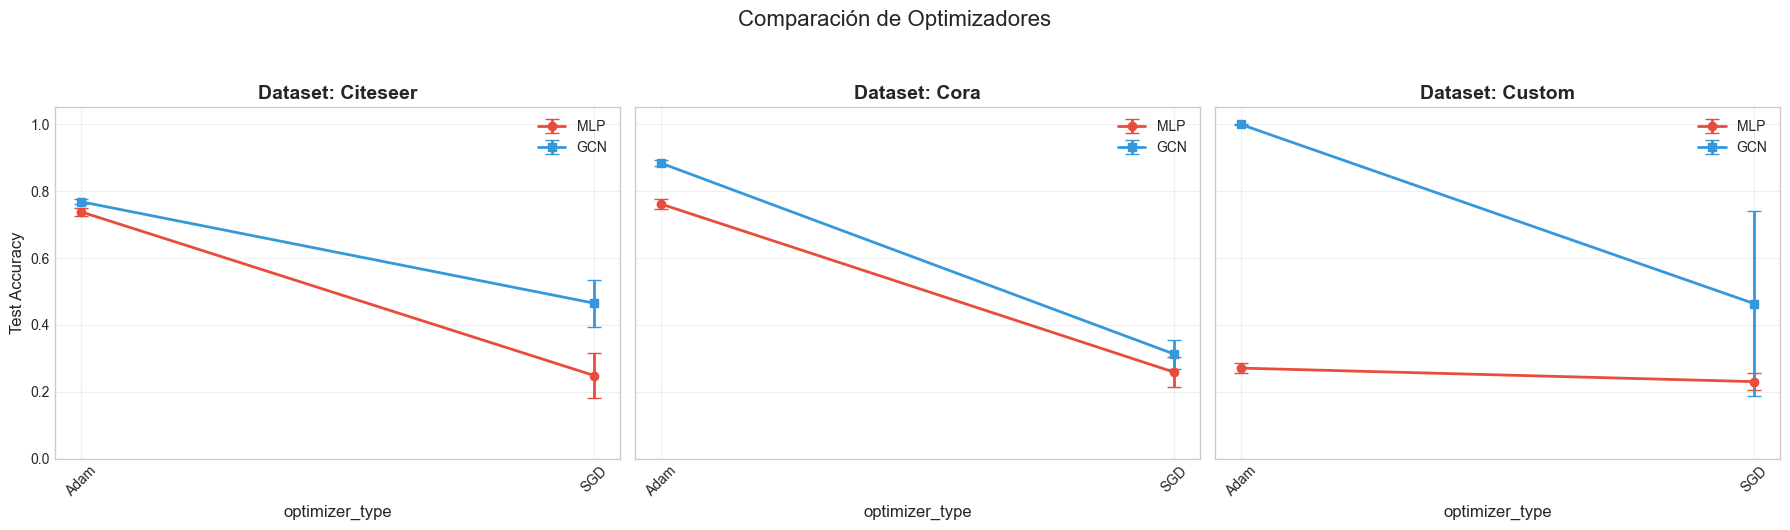

,Optimizer,Dataset,Model,Accuracy,Avg Epochs
0,Adam,Citeseer,GCN,0.7685 ± 0.0067,29
1,Adam,Citeseer,MLP,0.7384 ± 0.0119,28
2,Adam,Cora,GCN,0.8840 ± 0.0077,39
3,Adam,Cora,MLP,0.7617 ± 0.0148,44
4,Adam,Custom,GCN,0.9995 ± 0.0011,23
5,Adam,Custom,MLP,0.2710 ± 0.0142,33
6,SGD,Citeseer,GCN,0.4649 ± 0.0697,200
7,SGD,Citeseer,MLP,0.2486 ± 0.0670,82
8,SGD,Cora,GCN,0.3127 ± 0.0430,100
9,SGD,Cora,MLP,0.2586 ± 0.0449,62



— Curvas de entrenamiento para optimizer = SGD —


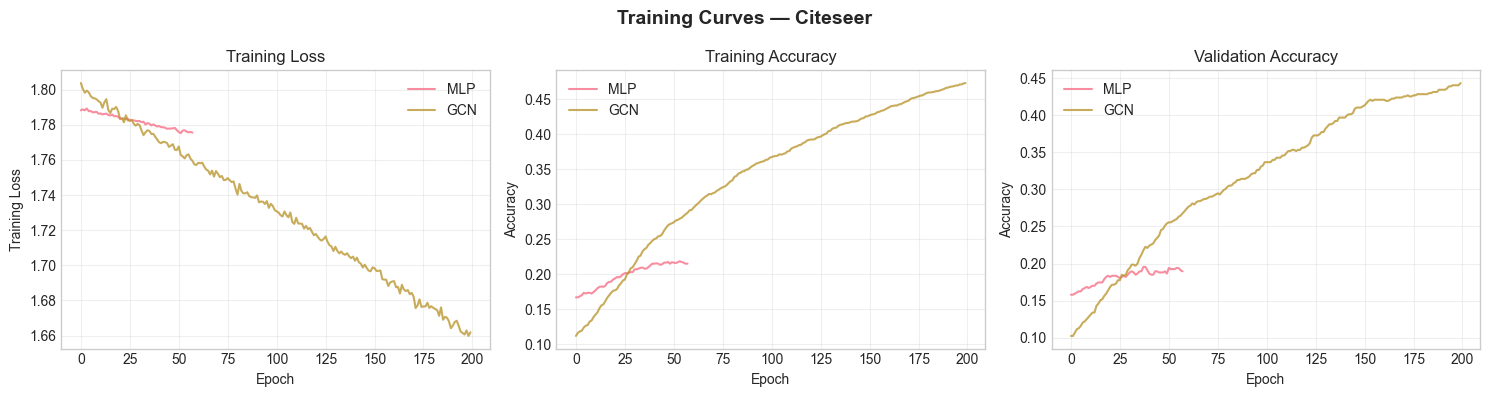

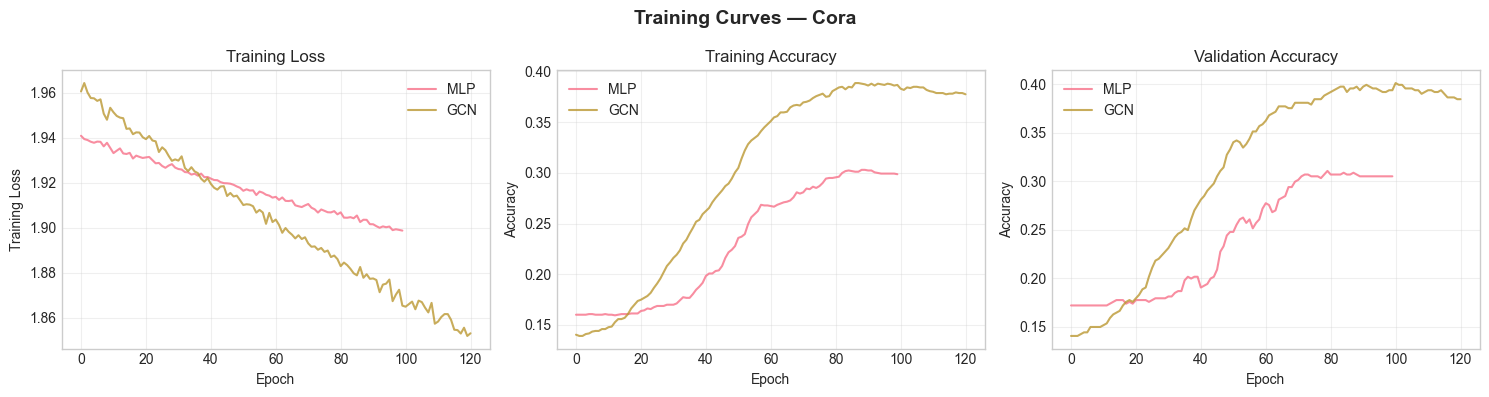

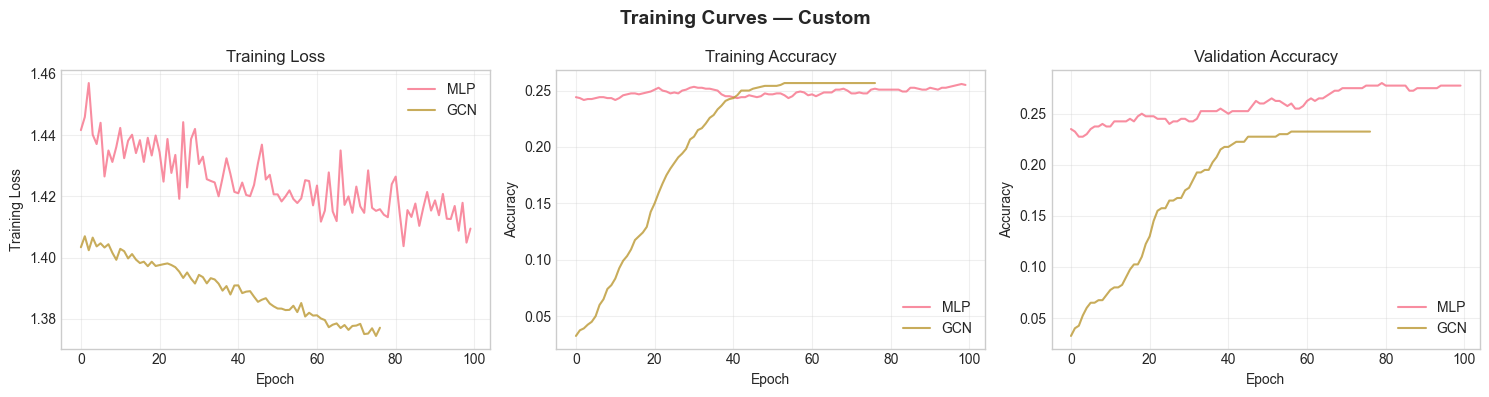

In [25]:
# Experiment: Optimizer
optimizers = ['Adam', 'SGD']
sweep_opt, trainers_opt = run_hyperparam_sweep('optimizer_type', optimizers, base_config, datasets_exp, exp_masks)
plot_hyperparam_sweep(sweep_opt, 'optimizer_type', optimizers,
                      'Comparación de Optimizadores', 'images/exp_optimizer.png')

# Summary table
display_sweep_table(sweep_opt, 'optimizer_type', 'Optimizer')

# Training curves for SGD
print("\n— Curvas de entrenamiento para optimizer = SGD —")
trainers_opt['SGD'].plot_training_curves(run = 0, filename = 'images/curves_sgd')


**Análisis de optimizadores (`Adam` vs `SGD`):**

El optimizador es el hiperparámetro con mayor impacto. Manteniendo `lr = 0.01` y sin *momentum* en SGD, se observan caídas fuertes con `SGD` frente a `Adam` en varios datasets/modelos.

La explicación práctica es que `Adam` utiliza tasas adaptativas por parámetro y suele converger más rápido y de forma más estable con features ruidosas o dispersas (como bag-of-words). `SGD` puede requerir una búsqueda más cuidadosa de `lr`, *momentum* y número de épocas para rendir de forma comparable.


### 5.6 Tabla resumen de todos los experimentos

In [ ]:
# Consolidate all hyperparameter sweep results into one summary table
all_sweeps = []
all_sweeps_raw = []

for name, df, param_col in [
    ('Hidden Dims', sweep_hidden, 'hidden_channels'),
    ('Learning Rate', sweep_lr, 'lr'),
    ('Dropout', sweep_dropout, 'dropout'),
    ('Weight Decay', sweep_wd, 'weight_decay'),
    ('Optimizer', sweep_opt, 'optimizer_type'),
]:
    df_copy = df.copy()
    df_copy['Experiment'] = name
    df_copy['Param Value'] = df_copy[param_col].astype(str)
    df_copy['Accuracy'] = df_copy.apply(lambda r: f"{r['mean']:.4f} ± {r['std']:.4f}", axis = 1)
    df_copy['Avg Epochs'] = df_copy['avg_epochs'].apply(lambda x: f"{x:.0f}")

    all_sweeps.append(df_copy[['Experiment', 'Param Value', 'Dataset', 'Model', 'Accuracy', 'Avg Epochs']])
    all_sweeps_raw.append(df_copy[['Experiment', 'Param Value', 'Dataset', 'Model', 'mean', 'avg_epochs']])

summary_all = pd.concat(all_sweeps, ignore_index = True)
summary_all_raw = pd.concat(all_sweeps_raw, ignore_index = True)

display(summary_all)

# How much each hyperparameter actually changes final accuracy
impact_by_experiment = (
    summary_all_raw
    .groupby(['Experiment', 'Dataset', 'Model'])['mean']
    .agg(['min', 'max'])
    .reset_index()
)
impact_by_experiment['Delta Accuracy'] = (impact_by_experiment['max'] - impact_by_experiment['min']).round(4)
impact_by_experiment = impact_by_experiment[['Experiment', 'Dataset', 'Model', 'Delta Accuracy']]
impact_by_experiment = impact_by_experiment.sort_values('Delta Accuracy', ascending = False)

display(impact_by_experiment)

# Where early stopping takes longest (largest avg epochs)
early_stop_hotspots = summary_all_raw.copy()
early_stop_hotspots = early_stop_hotspots.sort_values('avg_epochs', ascending = False).head(12)
early_stop_hotspots['Mean Test Acc'] = early_stop_hotspots['mean'].round(4)
early_stop_hotspots['Avg Epochs'] = early_stop_hotspots['avg_epochs'].round(0).astype(int)
early_stop_hotspots = early_stop_hotspots[['Experiment', 'Param Value', 'Dataset', 'Model', 'Mean Test Acc', 'Avg Epochs']]

display(early_stop_hotspots)





,Experiment,Param Value,Dataset,Model,Accuracy,Avg Epochs
0,Hidden Dims,16,Citeseer,GCN,0.7667 ± 0.0159,36
1,Hidden Dims,16,Citeseer,MLP,0.7195 ± 0.0062,40
2,Hidden Dims,16,Cora,GCN,0.8807 ± 0.0057,52
3,Hidden Dims,16,Cora,MLP,0.7529 ± 0.0201,65
4,Hidden Dims,16,Custom,GCN,0.9995 ± 0.0011,37
...,...,...,...,...,...,...
85,Optimizer,SGD,Citeseer,MLP,0.2486 ± 0.0670,82
86,Optimizer,SGD,Cora,GCN,0.3127 ± 0.0430,100
87,Optimizer,SGD,Cora,MLP,0.2586 ± 0.0449,62
88,Optimizer,SGD,Custom,GCN,0.4635 ± 0.2756,108


,Experiment,Dataset,Model,Delta Accuracy
20,Optimizer,Cora,GCN,0.5713
22,Optimizer,Custom,GCN,0.5360
21,Optimizer,Cora,MLP,0.5031
19,Optimizer,Citeseer,MLP,0.4898
18,Optimizer,Citeseer,GCN,0.3036
23,Optimizer,Custom,MLP,0.0405
13,Learning Rate,Citeseer,MLP,0.0351
17,Learning Rate,Custom,MLP,0.0235
7,Hidden Dims,Citeseer,MLP,0.0222
11,Hidden Dims,Custom,MLP,0.0200


,Experiment,Param Value,Dataset,Model,Mean Test Acc,Avg Epochs
84,Optimizer,SGD,Citeseer,GCN,0.4649,200
27,Learning Rate,0.001,Cora,MLP,0.7587,131
88,Optimizer,SGD,Custom,GCN,0.4635,108
86,Optimizer,SGD,Cora,GCN,0.3127,100
26,Learning Rate,0.001,Cora,GCN,0.8755,95
85,Optimizer,SGD,Citeseer,MLP,0.2486,82
25,Learning Rate,0.001,Citeseer,MLP,0.7384,77
24,Learning Rate,0.001,Citeseer,GCN,0.7712,66
3,Hidden Dims,16,Cora,MLP,0.7529,65
87,Optimizer,SGD,Cora,MLP,0.2586,62


## 6. Discusión final y conclusiones

### 6.1 Comparación general MLP vs GCN

- **Dataset sintético (Custom / SBM):** la diferencia es extrema (GCN ≈ 1.00 vs MLP ≈ 0.27). Esto confirma el objetivo de diseño: cuando las features son prácticamente ruido, la topología se convierte en la principal fuente de información y el message passing permite quitar ruido a nivel comunitario.
- **Cora y Citeseer:** la GCN sigue mejorando de forma consistente, pero la brecha se reduce porque las features bag-of-words ya contienen señal semántica útil. La estructura del grafo aporta información complementaria (homofilia en redes de citas).

### 6.2 Sensibilidad a hiperparámetros

En el barrido realizado, `hidden_channels`, `dropout` y `weight_decay` producen cambios pequeños dentro de los rangos probados. El hiperparámetro crítico es el optimizador (Adam vs SGD), que cambia drásticamente la capacidad de alcanzar un buen óptimo bajo el mismo presupuesto de entrenamiento. El `learning rate` afecta especialmente al número de épocas hasta convergencia y a la estabilidad.

### 6.3 Respuestas a las preguntas de análisis

1. **Brecha MLP vs GCN entre datasets:** es máxima en el dataset sintético (features débiles + comunidades fuertes) y menor en Cora/Citeseer (features informativas). La explicación es directa: cuanto menos contenido discriminativo haya en $\mathbf{x}_i$, más valor aporta la estructura del grafo.
2. **Efecto de `hidden_channels`:** aumentar capacidad puede ayudar hasta cierto punto, pero aparece un régimen de rendimientos decrecientes (y potencial sobreajuste). En mis resultados, 32–64 suele ser suficiente y subir a 128 apenas mejora.
3. **Efecto del `dropout`:** en el rango probado el impacto es bajo; con early stopping activo, los modelos ya están razonablemente regularizados. En escenarios más ruidosos o arquitecturas más profundas, el efecto podría ser mayor.
4. **Diferencias en embeddings (t-SNE):** la GCN aprende embeddings con clusters bien separados (representaciones alineadas con comunidades), mientras que el MLP tiende a embeddings más mezclados cuando la topología es clave.

**Conclusión final:** este trabajo confirma empíricamente la idea central de las GNNs: cuando existe homofilia, el message passing permite integrar señal distribuida en la estructura del grafo y mejorar de forma consistente frente a modelos que ignoran conectividad.
